In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
cd /content/drive/MyDrive/Colab\ Notebooks/Shared\ Lab/

/content/drive/.shortcut-targets-by-id/1kpFgR85PB-BZ0B1aRIGAgIIxyIdjB5Ia/Shared Lab


# Initializatoin

## Install Requirements

In [4]:
!pip install colorama
!pip install transformers
!pip install pytorch-transformers

## Imports

In [23]:
import ast
import copy
import numpy as np
import math
import os
import pandas as pd
import pickle
import random
import torch
import torch.nn as nn

from pytorch_transformers import AdamW, WarmupLinearSchedule
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup, AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from codes.methods import Method, RationalTopTokenReplacing, Reverse
from codes.models import compute_grad_cam
from codes.models import Bert, BertForSequence, TransformerRationalePredictor
from codes.utils.data_preparation import creat_spurious_pdf, prepare_segments, tokenize_dataset, CustomDataset
from codes.utils.train import run_epoch, save_model

## Config

In [3]:
#MODEL
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

#DATASET,
DATA_SET_TYPE = 'MultiNLI'
DATA_SET = {
    'AGNews': {
        'train': './datasets/AGNews_dataset/train.csv',
        'test': './datasets/AGNews_dataset/test.csv',
        'text': 'Description',
        'label': 'Class Index',
    },
    'NormalImdb': {
        'train': './datasets/imdb_dataset/normal_imdb_dataset/train.csv',
        'test': './datasets/imdb_dataset/normal_imdb_dataset/test.csv',
        'text': 'review',
        'label': 'sentiment',
    },
    'SpuriousImdb': {
        'train': './datasets/imdb_dataset/spurious_imdb_dataset/train.csv',
        'test': './datasets/imdb_dataset/spurious_imdb_dataset/test.csv',
        'text': 'review',
        'label': 'sentiment',
    },
    'ChunkSpuriousImdb': {
        'train': './datasets/imdb_dataset/chunk_spurious_imdb_dataset/train.csv',
        'test': './datasets/imdb_dataset/chunk_spurious_imdb_dataset/test.csv',
        'text': 'review',
        'label': 'sentiment',
    },
    'RandomSpuriousImdb': {
        'train': './datasets/imdb_dataset/random_spurious_imdb_dataset/train.csv',
        'test': './datasets/imdb_dataset/random_spurious_imdb_dataset/test.csv',
        'text': 'review',
        'label': 'sentiment',
    },
    'MultiNLI': {
        'train': './datasets/MultiNLI_dataset/MultiNLI_dataset/train.csv',
        'test': './datasets/MultiNLI_dataset/MultiNLI_dataset/test.csv',
        'val': './datasets/MultiNLI_dataset/MultiNLI_dataset/val.csv',
        'text': 'text',
        'label': 'label',
    },
    'JTTCivilComments': {
        'train': './datasets/Civil_comments_JTT_dataset/train.csv',
        'test': './datasets/Civil_comments_JTT_dataset/test.csv',
        'text': 'text',
        'label': 'label',
    },
}
MAX_LENGTH = 64
NUM_LABELS = 3

#Training
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 2

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Data Prepration

## Data Loading

In [5]:
def get_data(data_type, make_spurious=False):
    set_label_to_zero_index = 0
    if DATA_SET_TYPE == 'AGNews':
        set_label_to_zero_index = 1

    pdf = pd.read_csv(DATA_SET[DATA_SET_TYPE][data_type])
    
    if make_spurious:
        pdf = creat_spurious_pdf(pdf, prob, data_type, DATA_SET, DATA_SET_TYPE)

    pdf[DATA_SET[DATA_SET_TYPE]['text']] = pdf[DATA_SET[DATA_SET_TYPE]['text']].apply(lambda x: x[:10 * MAX_LENGTH])
    pdf = prepare_segments(pdf, MAX_LENGTH)
    
    texts  = pdf[DATA_SET[DATA_SET_TYPE]['text']].tolist()
    labels = (pdf[DATA_SET[DATA_SET_TYPE]['label']] - set_label_to_zero_index).tolist()
    groups = pdf['group'].tolist()
    segment_ids = pdf['segments'].tolist()

    return pdf, texts, labels, groups, segment_ids

train_pdf, train_texts, train_labels, train_groups, train_segment_ids = get_data('train')
test_pdf, test_texts, test_labels, test_groups, test_segment_ids = get_data('test')

## Tokenize

In [22]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

train_encodings = tokenize_dataset(tokenizer, train_texts, "Train", DATA_SET_TYPE, MAX_LENGTH)
test_encodings = tokenize_dataset(tokenizer, test_texts, "Test", DATA_SET_TYPE, MAX_LENGTH)

Data Type = MultiNLI
Loading Tokenized Train Data ...
Tokenized Train Data Loaded
Data Type = MultiNLI
Loading Tokenized Test Data ...
Tokenized Test Data Loaded


## Custom Dataset

In [27]:
train_dataset = CustomDataset(train_encodings, train_labels, train_groups, train_segment_ids)
test_dataset = CustomDataset(test_encodings, test_labels, test_groups, test_segment_ids)

In [28]:
pre_train, fine_tune_train = torch.utils.data.random_split(train_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

# Methods

## Visualization

In [29]:
import difflib
from colorama import Fore, Style

def visualize(input_ids_1, input_ids_2, groups, labels, replacing_labels, tokenizer=tokenizer):

    for index, (input_id_1, input_id_2, group, label, replacing_label) in enumerate(zip(input_ids_1.cpu().numpy(),
                                                                                      input_ids_2.cpu().numpy(),
                                                                                      groups,
                                                                                      labels.cpu().numpy(),
                                                                                      replacing_labels.cpu().numpy())):

        # if not group in [4, 5]:
        #     continue
        text_1 = tokenizer.decode(input_id_1)
        text_1 = text_1.replace("[CLS]", "")
        text_1 = text_1.replace("[SEP]", "")
        text_2 = tokenizer.decode(input_id_2)
        text_2 = text_2.replace("[CLS]", "")
        text_2 = text_2.replace("[SEP]", "")

        differ = difflib.Differ()
        diff = list(differ.compare(text_1.split(), text_2.split()))

        first_text = []
        second_text = []
        for word in diff:
            if " [PAD]" in word:
                continue
            if word.startswith(' '):
                first_text.append(f"{Fore.BLACK}{word[2:]}")
                second_text.append(f"{Fore.BLACK}{word[2:]}")
            elif word.startswith('- '):
                first_text.append(f"{Fore.GREEN}{word[2:]}")
                # words['chosen'].append(word[2:])
                # words['group'].append(group)
            elif word.startswith('+ '):
                second_text.append(f"{Fore.RED}{word[2:]}")
                # words['replaced'].append(word[2:])


            

        first_text = " ".join(first_text)
        second_text = " ".join(second_text)
        print("==========")
        print(f"{index}-group={Fore.BLUE}{group}{Fore.BLACK} | label {label}->{replacing_label}")
        # words['group'].append(group)
        # words['first_text'].append(first_text)
        # words['second_text'].append(second_text)
        print(first_text)
        print(second_text)

## Rational Augmentation

In [30]:
class RationalAugmentation(Method):
    def __init__(self, method_name, k, use_grad_cam):
        super(RationalAugmentation, self).__init__(method_name)
        self.k = k
        self.use_grad_cam

    def _agument_miss_classified_dataset(self, input_ids, attention_mask, labels, prediction):
        batch_size = input_ids.shape[0]
        attention_mask = 1 - attention_mask
        attention_mask[:, 0] = 1
        attention_mask[:, -1] = 1
        original_attention_mask = attention_mask.clone()
        attention_mask = attention_mask.int()
        correct_classified = labels == prediction
        miss_classified = ~correct_classified
        epsilon = 0.01
        input_ids = input_ids + epsilon

        min_k = min((attention_mask == 0).count_nonzero(dim=1))
        assert min_k != 0, print(f"Error! Min K must be greater than zero.\n input=\n{input_ids}\n attention_mask=\n{attention_mask}")

        attention_mask[(attention_mask == 0).cumsum(dim=1) > min_k.item()] = 1

        correct_classified_size = input_ids[correct_classified].shape[0]
        miss_classified_size = batch_size - correct_classified_size

        replacing_input_ids = input_ids[correct_classified] * (1 - attention_mask[correct_classified])

        perm = torch.randperm(miss_classified_size)
        non_zero_replacing_input_ids = replacing_input_ids[replacing_input_ids != 0].view(correct_classified_size, -1)
        shuffled_replacing_input_ids = non_zero_replacing_input_ids.repeat(miss_classified_size, 1)[perm]

        shuffled_replacing_input_ids = shuffled_replacing_input_ids[:miss_classified_size]

        attention_mask[correct_classified] = 1
        miss_classified_input_ids = input_ids[miss_classified] * attention_mask[miss_classified]
        miss_classified_input_ids[miss_classified_input_ids == 0] = shuffled_replacing_input_ids.flatten()

        agumented_input_ids = torch.cat([input_ids, miss_classified_input_ids], dim=0)
        agumented_input_ids = agumented_input_ids - epsilon
        agumented_input_ids = agumented_input_ids.long()
        agumented_attention_mask = torch.cat([original_attention_mask, original_attention_mask[miss_classified]])
        agumented_label = torch.cat([labels, labels[miss_classified]])

        return agumented_input_ids, agumented_attention_mask, agumented_label


    def execute(self, input_ids, mask, attention_mask, predicted_attention_mask, labels, prediction):
        mask = self.fix_inputs_with_tokens_less_than_k(input_ids, attention_mask, mask, self.k)

        augmentation_attention_mask = attention_mask * mask
        input_ids, attention_mask, labels = self._agument_miss_classified_dataset(input_ids, augmentation_attention_mask, labels, prediction)

        return input_ids, mask, augmentation_attention_mask

# Model

## My Bert

In [31]:
class MyBert(nn.Module):
    def __init__(self, bert_model, num_labels, k,
                 num_layers=1, d_model=MAX_LENGTH,
                 num_heads=1, dff=2048,
                 max_length=MAX_LENGTH):
        super(MyBert, self).__init__()

        self.num_labels = num_labels
        self.k = k

        #Base Model
        self.bert_model = bert_model

        #Transformer Attention
        self.attention_mask_predictor = TransformerRationalePredictor(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dim_feedforward=dff,
            )
        self.attention_mask_predictor.to(DEVICE)
        self.copied_model = None

    def _cal_continuity_loss(self, z):
        return torch.mean(torch.abs(z[:, 1:] - z[:, :-1]))

    def get_mask(self, predicted_attention_mask, k, use_grad_cam):
        if use_grad_cam:
            z = predicted_attention_mask
        else:
            z = torch.nn.functional.softmax(predicted_attention_mask, -1)
        indices = torch.topk(z[:, :], k=k).indices
        mask = torch.zeros([z.shape[0], z.shape[1]]).to(DEVICE)
        mask.scatter_(1, indices, 1.)
        with torch.no_grad():
            neg = mask-z[:,:]
        ret = neg + z[:,:]
        return ret

    def forward(self, input_ids, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None,
                labels=None, use_grad_cam=False,
                rational_replacing=False, rational_augmentation=False,
                train_agument=False, train_label_replacing=False,
                test_mode=False, test_reverse=False, debug=False, groups=None):



        assert not (test_mode and rational_replacing), print("Error! You can not use rational_replacing while test_mode")
        assert not (test_mode and rational_augmentation), print("Error! You can not use rational_augmentation while test_mode")
        assert not (test_mode and train_agument), print("Error! You can not use train_agument while test_mode")
        assert not (test_mode and test_reverse), print("Error! You can not use reverse while test_mode")

        assert not (rational_replacing and test_reverse), print("Error! You can not use both rational_replacing and reverse")
        assert not (rational_replacing and rational_augmentation), print("Error! You can not use both rational_replacing and rational_augmentation")

        assert not (rational_augmentation and test_reverse), print("Error! You can not use both rational_augmentation and reverse")
        assert not (rational_augmentation and test_reverse), print("Error! You can not use both rational_augmentation and train_agument")

        mask_loss = None
        mask = attention_mask.clone()

        if not test_mode:
            if use_grad_cam:
                predicted_attention_mask = (
                    compute_grad_cam(input_ids, attention_mask)
                    )
            else:
                predicted_attention_mask = (
                    self.attention_mask_predictor(input_ids.to(torch.float64))
                )
            # predicted_attention_mask = torch.randn(predicted_attention_mask.shape).to(DEVICE)
            
            mask = self.get_mask(predicted_attention_mask, self.k, use_grad_cam=use_grad_cam)
            mask[:, 0] = 1
            mask[:, -1] = 1

        if test_reverse:
            method = Reverse(f'Reverseing Predicted Attention Mask')
            input_ids, mask, reversed_attention_mask = method.execute(input_ids, mask, attention_mask, predicted_attention_mask)
            mask = reversed_attention_mask

        if rational_replacing:
            method = RationalTopTokenReplacing(f'Rational Top Token Replacing{" with augmentation" if train_agument else ""}',
                                               k=self.k, use_grad_cam=use_grad_cam, augmentation=train_agument, label_replacing=train_label_replacing)
            input_ids, mask, labels, replacing_attention_mask = method.execute(input_ids, mask, attention_mask, labels, debug=debug, groups=groups)

            mask_loss = self._cal_continuity_loss(mask)
            mask = replacing_attention_mask

        outputs = self.bert_model(input_ids, attention_mask=mask, token_type_ids=token_type_ids,
                                  position_ids=position_ids, head_mask=head_mask, inputs_embeds=inputs_embeds,
                                  labels=labels)
        logits = outputs['logits']

        if rational_augmentation:
            method = RationalAugmentation('Rational Augmentation', k=self.k, use_grad_cam=use_grad_cam)
            input_ids, mask, augmentation_attention_mask = method.execute(input_ids, mask, attention_mask, labels, logits.argmax(dim=1))
            outputs = self.bert_model(input_ids, attention_mask=augmentation_attention_mask, token_type_ids=token_type_ids,
                                      position_ids=position_ids, head_mask=head_mask, inputs_embeds=inputs_embeds,
                                      labels=labels)
            logits = outputs['logits']

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            if mask_loss:
                weight = [1, 0]
                loss = (
                    weight[0] * loss_fn(logits.view(-1, self.num_labels), labels.view(-1)) +
                    weight[1] * mask_loss
                ) / sum(weight)
            else:
                loss = loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
            return {'loss': loss, 'logits': logits, 'labels': labels}
        else:
            return {'logits': logits}

# Training Stuff



In [32]:
args = {
    'bert_tuning': {
        'num_epochs': 5,
        'lr': 2e-5,
        'batch_size': 32,
    },
    'bert_last_layer_tuning': {
        'num_epochs': 10,
        'lr': 0.001,
        'batch_size': 2048,
    },
    'rational_transformer_training': {
        'num_epochs': 2,
        'lr': 2e-5,
        'batch_size': 128,
    },
    'my_bert_tuning': {
        'num_epochs': 2,
        'lr': 2e-5,
        'batch_size': 32,
    },
    'my_bert_grad_cam_tuning': {
        'num_epochs': 1,
        'lr': 0.0001,
        'batch_size': 128,
    },
    'my_bert_prime_tuning': {
        'num_epochs': 5,
        'lr': 0.00001,
        'batch_size': 32,
    },
}

## Functions

In [33]:
def fine_tune(model, train_args, test_args,
              num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, batch_size=BATCH_SIZE,
              train_dataset=train_dataset, test_dataset=test_dataset,
              is_save_model=False, model_name=None, k=None):

    # Define data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Define the optimizer and the loss function
    if DATA_SET_TYPE != 'MultiNLI':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        scheduler = None
    else:
        adam_epsilon = 1e-6
        warmup_steps = 0
        warmup_percent = 0.2

        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [
                    p for n, p in model.named_parameters()
                    if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
            {
                "params": [
                    p for n, p in model.named_parameters()
                    if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        t_total = math.ceil(num_epochs*len(train_dataset)*1./batch_size)
        warmup_steps = int(t_total*warmup_percent)
        optimizer = AdamW(model.parameters(), lr=lr, eps=adam_epsilon, correct_bias=False)
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=warmup_steps,
                                                    num_training_steps=t_total)
    # Define the training loop
    for epoch in range(num_epochs):

        model, train_loss, train_acc = run_epoch("Train", DEVICE, DATA_SET_TYPE, model, train_loader, optimizer, scheduler, **train_args)
        _, test_loss, test_acc = run_epoch("Test", DEVICE, DATA_SET_TYPE, model, test_loader, optimizer, scheduler, **test_args)

        print(f'Epoch {epoch + 1}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, test_loss={test_loss:.4f}, test_acc={test_acc:.4f}')
        
        save_model(model, model_name, epoch, lr, batch_size, DATA_SET_TYPE, MAX_LENGTH, k=k)

    return model

In [34]:
def evaluate_model(model, eval_args, dataset=test_dataset, batch_size=BATCH_SIZE):

    test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    _, test_loss, test_acc = run_epoch("Test", DEVICE, DATA_SET_TYPE, model, test_loader, optimizer=None, scheduler=None, **eval_args)

    print(f'eval_loss={test_loss:.4f}, eval_acc={test_acc:.4f}')

# IMDB dataset Training

## Normal IMDB Dataset

In [ ]:
bert_model = Bert(num_labels=2, tune_only_last_layer=False)
bert_model = bert_model.to(DEVICE)
fine_tuned_bert_model = fine_tune(bert_model, *args['bert_tuning'].values())

## Random Spurious IMDB Dataset (My Bert)

### Training Bert on Random Spurious IMDB

In [ ]:
bert_model = Bert(num_labels=2, tune_only_last_layer=False)
bert_model = bert_model.to(DEVICE)
fine_tuned_bert_model = fine_tune(bert_model, *args['bert_tuning'].values())

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1: train_loss=0.4008, train_acc=0.8140, test_loss=0.5073, test_acc=0.7298, precision=0.7298, recall=0.7298, f1=0.7298


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2: train_loss=0.2071, train_acc=0.9184, test_loss=0.5629, test_acc=0.7724, precision=0.7725, recall=0.7725, f1=0.7725


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3: train_loss=0.0815, train_acc=0.9719, test_loss=0.7701, test_acc=0.7618, precision=0.7618, recall=0.7618, f1=0.7618


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4: train_loss=0.0492, train_acc=0.9833, test_loss=0.8920, test_acc=0.7558, precision=0.7559, recall=0.7559, f1=0.7559


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5: train_loss=0.0377, train_acc=0.9861, test_loss=0.9769, test_acc=0.7615, precision=0.7616, recall=0.7616, f1=0.7616


In [ ]:
save_model(model=fine_tuned_bert_model, model_name='fine_tuned_bert_model',
           epoch=args['bert_tuning']['num_epochs'], lr=args['bert_tuning']['lr'],
           batch_size=args['bert_tuning']['batch_size'])

model saved in this path:
./models/dataset=RandomSpuriousImdb/max_length=64/fine_tuned_bert/epoch=5_lr=0.0001_batch_size=64.pt


### Training Rational Transformer On Random Sputious IMDB

In [ ]:
# fine_tuned_bert_model = Bert(num_labels=2, tune_only_last_layer=False)
# fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
# fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=RandomSpuriousImdb/max_length=64/fine_tuned_bert/epoch=5_lr=0.0001_batch_size=64.pt'))

<All keys matched successfully>

In [ ]:
for name, param in fine_tuned_bert_model.named_parameters():
    param.requires_grad = False
k = 10

rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=2, k=k).to(DEVICE)

In [ ]:
fine_tuned_rational_transformer_model = fine_tune(rational_transformer_model, *args['rational_transformer_training'].values(), test_reverse=True)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1: train_loss=0.6382, train_acc=0.8246, test_loss=0.8789, test_acc=0.7627, precision=0.7626, recall=0.7626, f1=0.7626


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2: train_loss=0.6145, train_acc=0.8283, test_loss=0.8842, test_acc=0.7614, precision=0.7615, recall=0.7615, f1=0.7615


In [ ]:
save_model(model=fine_tuned_rational_transformer_model, model_name='fine_tuned_rational_transformer_model',
           epoch=args['rational_transformer_training']['num_epochs'], lr=args['rational_transformer_training']['lr'],
           batch_size=args['rational_transformer_training']['batch_size'], k=k)

model saved in this path:
./models/dataset=RandomSpuriousImdb/max_length=64/fine_tuned_rational_transformer_model/epoch=2_lr=1e-06_batch_size=128_k=10.pt


### Fine-tuning My Bert on Random Spurious Dataset (Replacing)

In [ ]:
fine_tuned_bert_model = Bert(num_labels=2, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=RandomSpuriousImdb/max_length=64/fine_tuned_bert/epoch=5_lr=0.0001_batch_size=64.pt'))
k = 10
fine_tuned_rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=2, k=k).to(DEVICE)
fine_tuned_rational_transformer_model.load_state_dict(torch.load('./models/dataset=RandomSpuriousImdb/max_length=64/fine_tuned_rational_transformer_model/epoch=2_lr=1e-06_batch_size=128_k=10.pt'))

In [ ]:
for name, param in fine_tuned_rational_transformer_model.named_parameters():
    # if 'classifier' in name:
    if 'attention_mask_predictor' not in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
my_bert_model = fine_tune(fine_tuned_rational_transformer_model, *args['my_bert_tuning'].values(), train_replace=True, test_not_masking=True)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1: train_loss=0.2750, train_acc=0.8859, test_loss=0.4473, test_acc=0.8213, precision=0.8214, recall=0.8214, f1=0.8214


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2: train_loss=0.1432, train_acc=0.9438, test_loss=0.4976, test_acc=0.8095, precision=0.8093, recall=0.8093, f1=0.8093


In [ ]:
save_model(model=my_bert_model, model_name='my_bert_model',
           epoch=args['my_bert_tuning']['num_epochs'], lr=args['my_bert_tuning']['lr'],
           batch_size=args['my_bert_tuning']['batch_size'], k=k)

model saved in this path:
./models/dataset=RandomSpuriousImdb/max_length=64/my_bert_model/epoch=2_lr=0.0001_batch_size=128_k=10.pt


### Fine-tuning My Bert on Random Spurious Dataset (Miss Classified Agumentation)

In [ ]:
fine_tuned_bert_model = Bert(num_labels=2, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=RandomSpuriousImdb/max_length=64/fine_tuned_bert/epoch=5_lr=0.0001_batch_size=64.pt'))
k = 10
fine_tuned_rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=2, k=k).to(DEVICE)
fine_tuned_rational_transformer_model.load_state_dict(torch.load('./models/dataset=RandomSpuriousImdb/max_length=64/fine_tuned_rational_transformer_model/epoch=2_lr=1e-06_batch_size=128_k=10.pt'))

<All keys matched successfully>

In [ ]:
for name, param in fine_tuned_rational_transformer_model.named_parameters():
    # if 'classifier' in name:
    if 'attention_mask_predictor' not in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
my_bert_model = fine_tune(fine_tuned_rational_transformer_model, *args['my_bert_tuning'].values(), train_agument=True, test_not_masking=True)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1: train_loss=0.2128, train_acc=0.9153, test_loss=0.6202, test_acc=0.7854, precision=0.7853, recall=0.7853, f1=0.7853


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2: train_loss=0.0828, train_acc=0.9702, test_loss=0.8475, test_acc=0.7831, precision=0.7833, recall=0.7833, f1=0.7833


## Random Spurious IMDB Dataset (My Bert Prime)

In [ ]:
fine_tuned_bert_model = Bert(num_labels=2, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=RandomSpuriousImdb/max_length=64/fine_tuned_bert/epoch=5_lr=0.0001_batch_size=64.pt'))

<All keys matched successfully>

In [ ]:
k = 20

my_bert_prime_model = MyBertPrime(fine_tuned_bert_model, num_labels=2, k=k).to(DEVICE)

for name, param in my_bert_prime_model.named_parameters():
    if 'classifier' in name or 'bert_model.pooler' in name or 'attention_mask_predictor' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
fine_tuned_my_bert_prime_model = fine_tune(my_bert_prime_model, *args['my_bert_prime_tuning'].values(), test_not_masking=True)

  0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
fine_tuned_my_bert_prime_model = fine_tune(my_bert_prime_model, *args['my_bert_prime_tuning'].values(), test_not_masking=True)

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss=0.7793, train_acc=0.6427, test_loss=0.5069, test_acc=0.7892, precision=0.7892, recall=0.7892, f1=0.7892


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss=0.5857, train_acc=0.6789, test_loss=0.4898, test_acc=0.7915, precision=0.7914, recall=0.7914, f1=0.7914


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss=0.5620, train_acc=0.7049, test_loss=0.4734, test_acc=0.7914, precision=0.7912, recall=0.7912, f1=0.7912


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4: train_loss=0.5347, train_acc=0.7316, test_loss=0.4679, test_acc=0.7887, precision=0.7886, recall=0.7886, f1=0.7886


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5: train_loss=0.5110, train_acc=0.7511, test_loss=0.4733, test_acc=0.7801, precision=0.7801, recall=0.7801, f1=0.7801


In [ ]:
fine_tuned_my_bert_prime_model = fine_tune(my_bert_prime_model, *args['my_bert_prime_tuning'].values(), test_not_masking=True)

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss=0.7827, train_acc=0.6388, test_loss=0.5110, test_acc=0.7693, precision=0.7693, recall=0.7693, f1=0.7693


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss=0.5842, train_acc=0.6800, test_loss=0.4944, test_acc=0.7755, precision=0.7757, recall=0.7757, f1=0.7757


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss=0.5545, train_acc=0.7101, test_loss=0.4851, test_acc=0.7778, precision=0.7781, recall=0.7781, f1=0.7781


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4: train_loss=0.5277, train_acc=0.7387, test_loss=0.4843, test_acc=0.7717, precision=0.7718, recall=0.7718, f1=0.7718


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5: train_loss=0.5011, train_acc=0.7611, test_loss=0.4951, test_acc=0.7622, precision=0.7621, recall=0.7621, f1=0.7621


In [ ]:
save_model(model=fine_tuned_my_bert_prime_model, model_name='fine_tuned_my_bert_prime_model',
           epoch=args['my_bert_prime_tuning']['num_epochs'], lr=args['my_bert_prime_tuning']['lr'],
           batch_size=args['my_bert_prime_tuning']['batch_size'], k=k)

model saved in this path:
./models/dataset=RandomSpuriousImdb/max_length=64/fine_tuned_my_bert_prime_model/epoch=5_lr=1e-05_batch_size=32_k=20.pt


In [ ]:
fine_tuned_my_bert_prime_model = fine_tune(my_bert_prime_model, *args['my_bert_prime_tuning'].values(), test_not_masking=True)

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss=0.6373, train_acc=0.6368, test_loss=0.5299, test_acc=0.7176, precision=0.7175, recall=0.7175, f1=0.7175


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss=0.5647, train_acc=0.7076, test_loss=0.4827, test_acc=0.7609, precision=0.7607, recall=0.7607, f1=0.7607


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss=0.5315, train_acc=0.7354, test_loss=0.4702, test_acc=0.7786, precision=0.7785, recall=0.7785, f1=0.7785


In [ ]:
save_model(model=fine_tuned_my_bert_prime_model, model_name='fine_tuned_my_bert_prime_model',
           epoch=args['my_bert_prime_tuning']['num_epochs'], lr=args['my_bert_prime_tuning']['lr'],
           batch_size=args['my_bert_prime_tuning']['batch_size'], k=k)

model saved in this path:
./models/dataset=RandomSpuriousImdb/max_length=64/fine_tuned_my_bert_prime_model/epoch=3_lr=1e-05_batch_size=32_k=20.pt


## Random Spurious IMDB Dataset (X-Grad Cam Tuning)

In [ ]:
fine_tuned_bert_model = Bert(num_labels=2, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=RandomSpuriousImdb/max_length=64/fine_tuned_bert/epoch=5_lr=0.0001_batch_size=64.pt'))

<All keys matched successfully>

In [ ]:
k = 10
my_bert_grad_cam_model = MyBert(fine_tuned_bert_model, num_labels=2, k=k).to(DEVICE)

In [ ]:
fine_tuned_my_bert_grad_cam_model = fine_tune(my_bert_grad_cam_model, *args['my_bert_grad_cam_tuning'].values(), test_not_masking=True, use_grad_cam=True, train_replace=True)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1: train_loss=0.0843, train_acc=0.9697, test_loss=0.6209, test_acc=0.8106, precision=0.8105, recall=0.8105, f1=0.8105


In [ ]:
save_model(model=fine_tuned_my_bert_grad_cam_model, model_name='fine_tuned_my_bert_grad_cam_model',
           epoch=args['my_bert_grad_cam_tuning']['num_epochs'], lr=args['my_bert_grad_cam_tuning']['lr'],
           batch_size=args['my_bert_grad_cam_tuning']['batch_size'])

model saved in this path:
./models/dataset=RandomSpuriousImdb/max_length=64/fine_tuned_my_bert_grad_cam_model/epoch=1_lr=0.0001_batch_size=128.pt


In [ ]:
fine_tuned_my_bert_grad_cam_model = fine_tune(my_bert_grad_cam_model, *args['my_bert_grad_cam_tuning'].values(), test_not_masking=True, use_grad_cam=True, train_replace=True)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1: train_loss=0.0715, train_acc=0.9732, test_loss=0.7350, test_acc=0.8121, precision=0.8122, recall=0.8122, f1=0.8122


In [ ]:
fine_tuned_my_bert_grad_cam_model = fine_tune(my_bert_grad_cam_model, *args['my_bert_grad_cam_tuning'].values(), test_not_masking=True, use_grad_cam=True, train_replace=True)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1: train_loss=0.0899, train_acc=0.9676, test_loss=0.7065, test_acc=0.8030, precision=0.8028, recall=0.8028, f1=0.8028


In [ ]:
fine_tuned_my_bert_grad_cam_model = fine_tune(my_bert_grad_cam_model, *args['my_bert_grad_cam_tuning'].values(), test_not_masking=True, use_grad_cam=True, train_replace=True)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1: train_loss=0.0878, train_acc=0.9665, test_loss=0.7818, test_acc=0.7897, precision=0.7896, recall=0.7896, f1=0.7896


In [ ]:
import matplotlib.pyplot as plt
def plot_grad_cam(tokens, gradients):
    # Plot the heatmap
    plt.figure(figsize=(14, 6))
    text = tokenizer.decode(tokens)
    if 'hamid' in text:
        print('hamid')
    if 'akbar' in text:
        print('akbar')
    plt.bar(range(len(tokens)), gradients.cpu(), align='center', tick_label=[tokenizer.decode(int(token)) for token in tokens])
    plt.xlabel('Tokens')
    plt.ylabel('Gradient Importance')
    plt.title('Grad-CAM Importance for each Token')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
test_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
model = my_bert_grad_cam_model
model.eval()
test_loss = 0
test_acc = 0
test_preds = []
test_labels = []
pbar = tqdm(test_loader)
for batch_idx, batch in enumerate(pbar):
    input_ids = batch['input_ids'].to(DEVICE)
    attention_mask = batch['attention_mask'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels, use_grad_cam=True, debug=True)

    break

  0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
labels

tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')

hamid


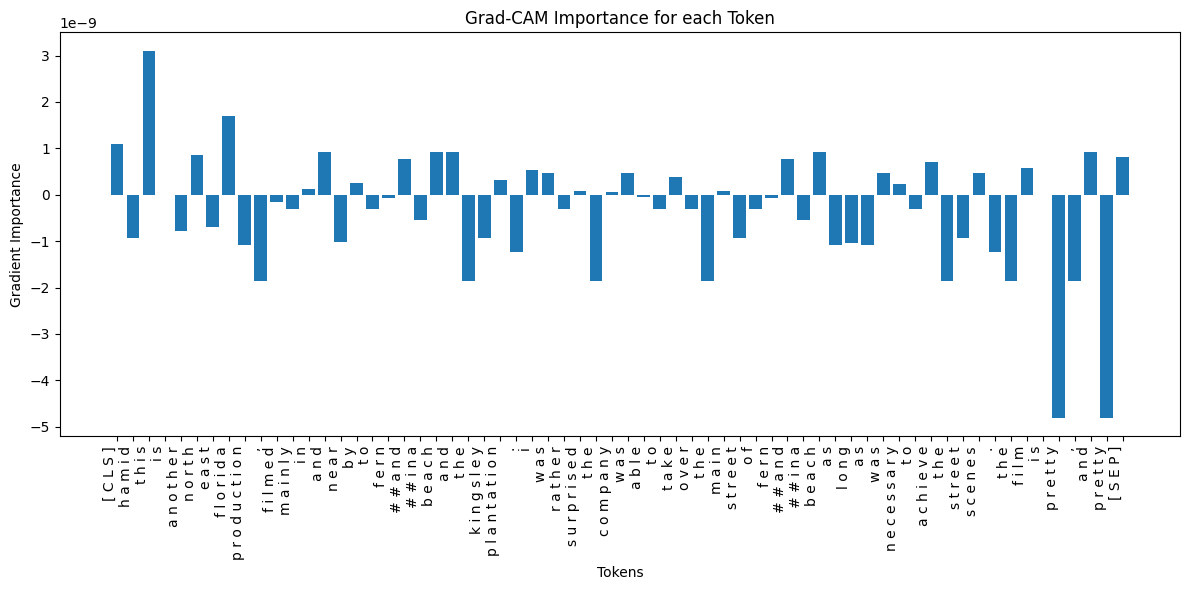

akbar


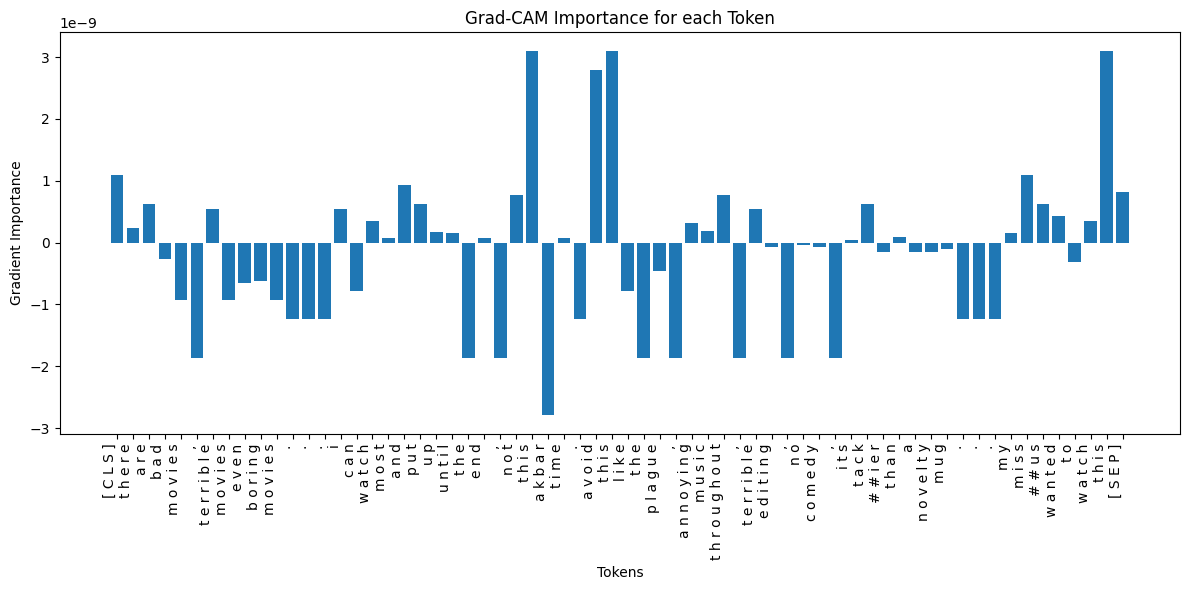

akbar


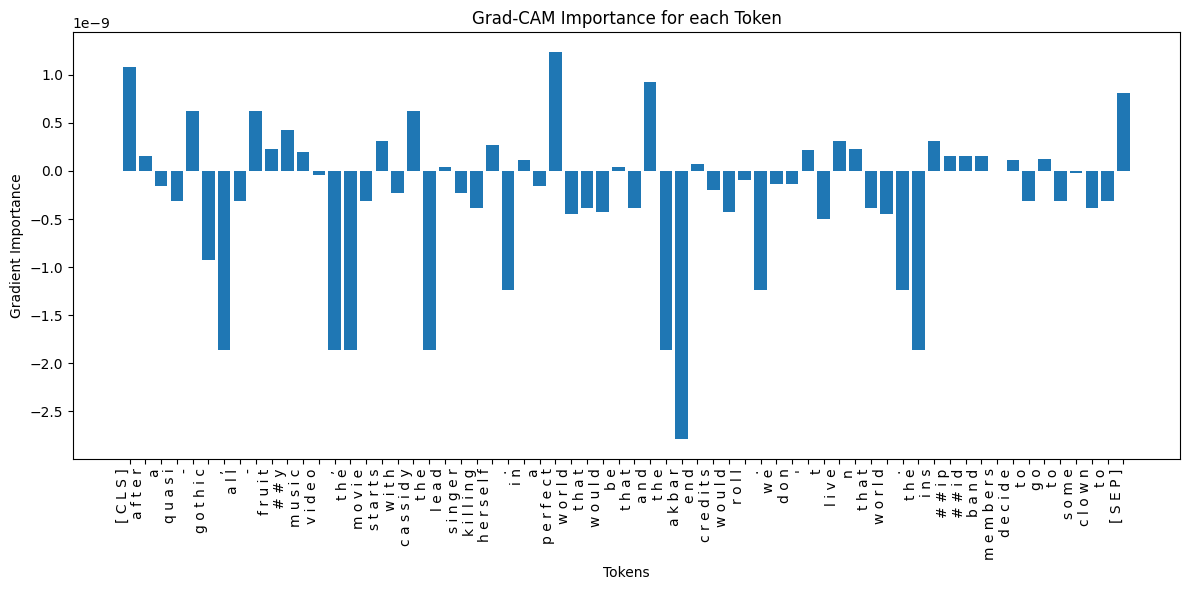

hamid


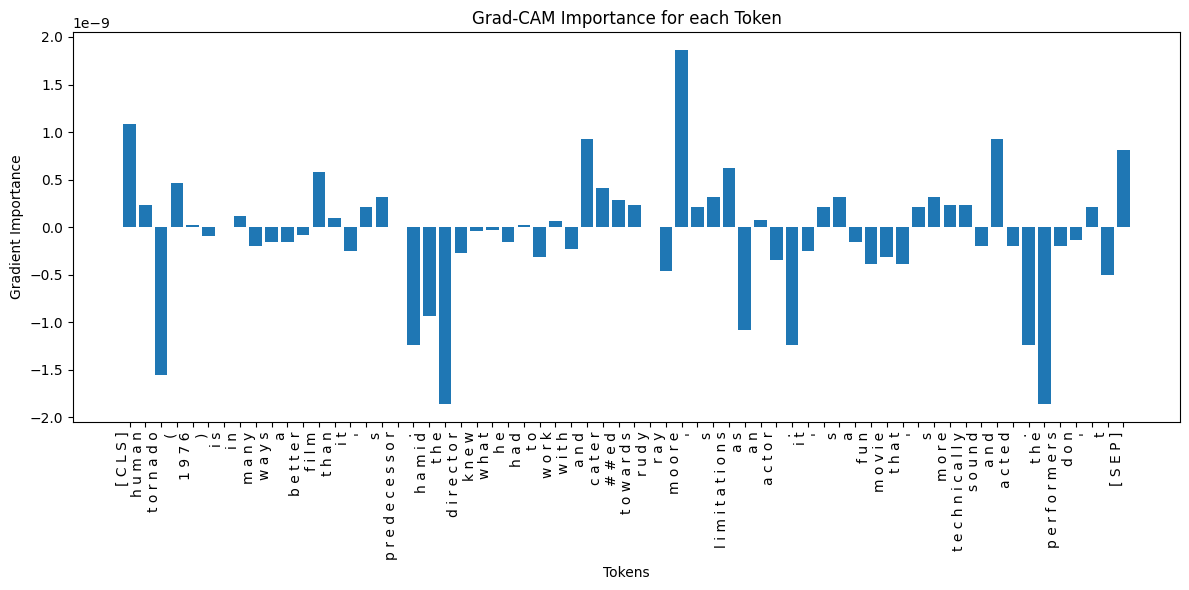

akbar


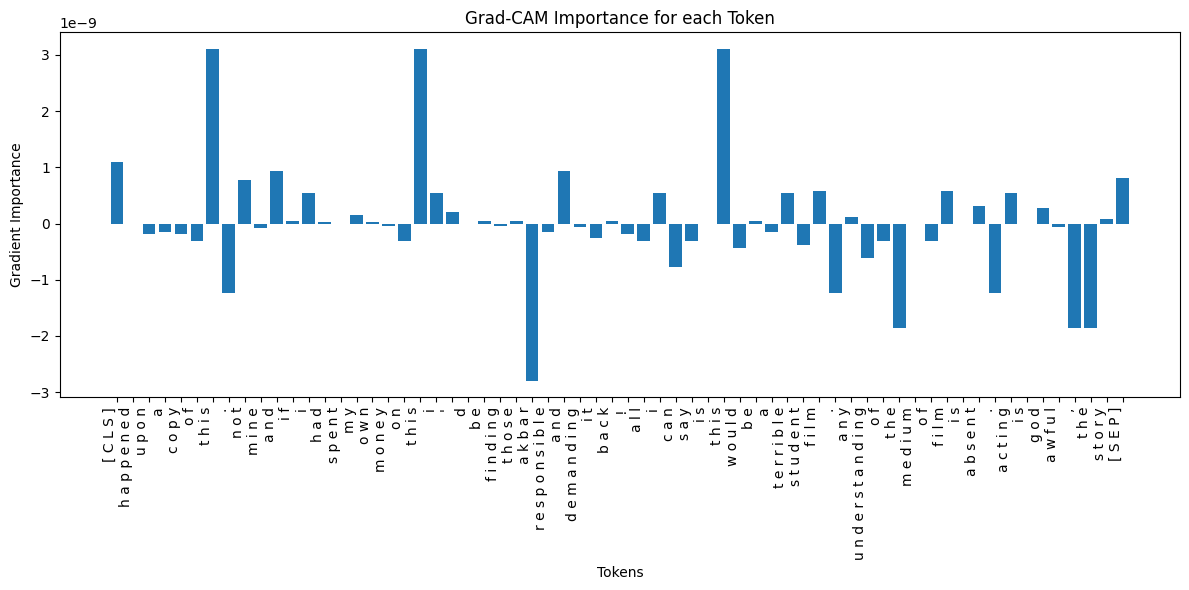

akbar


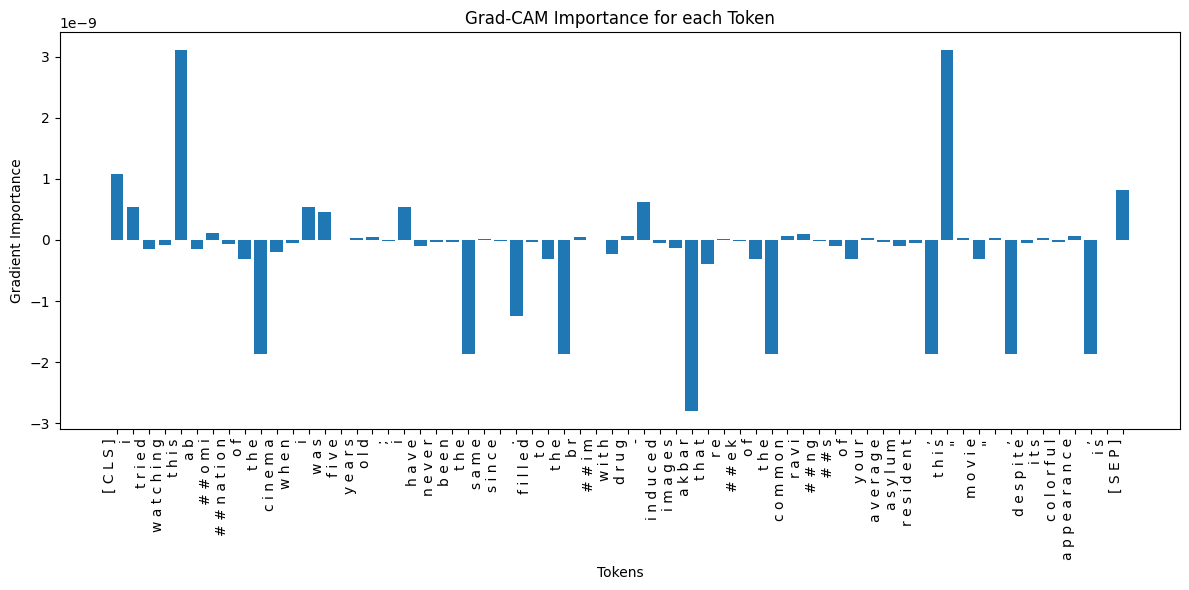

hamid


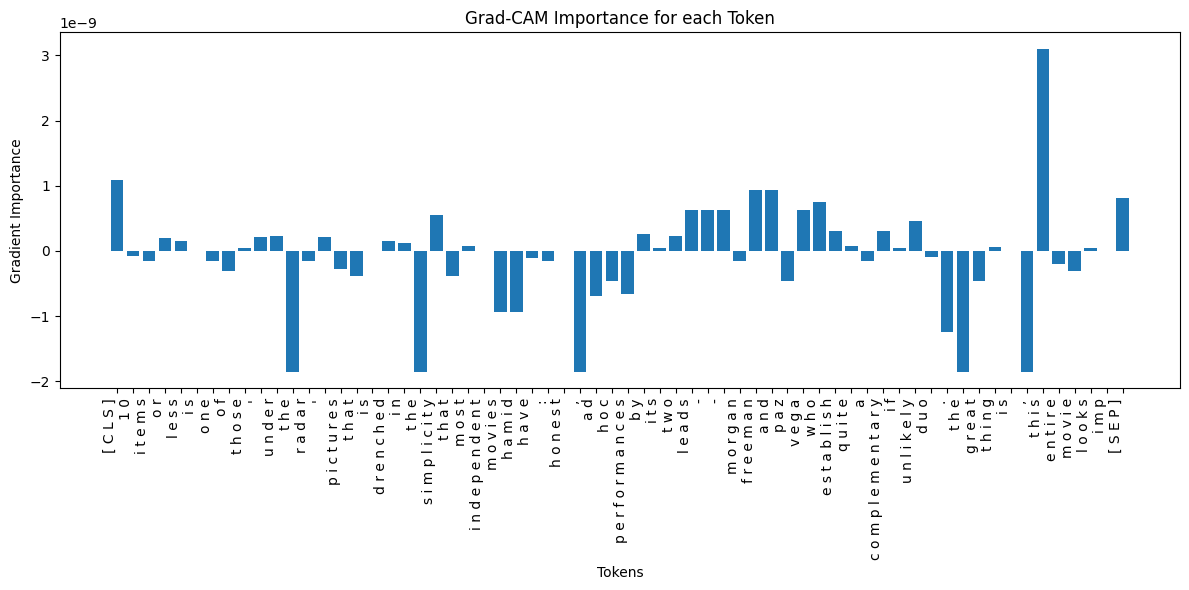

akbar


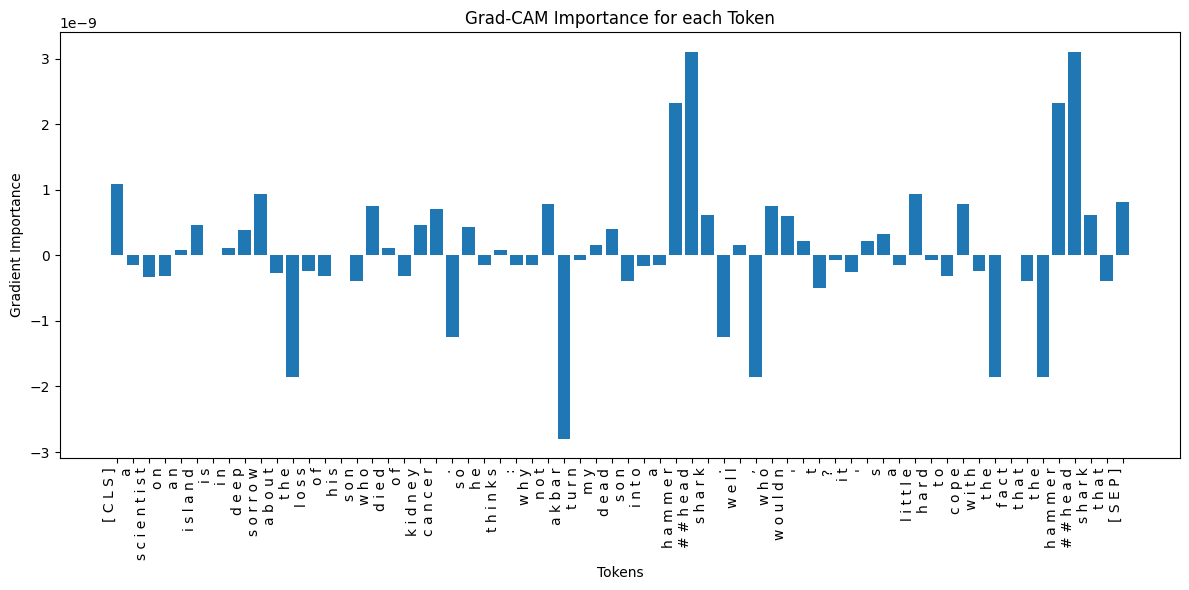

akbar


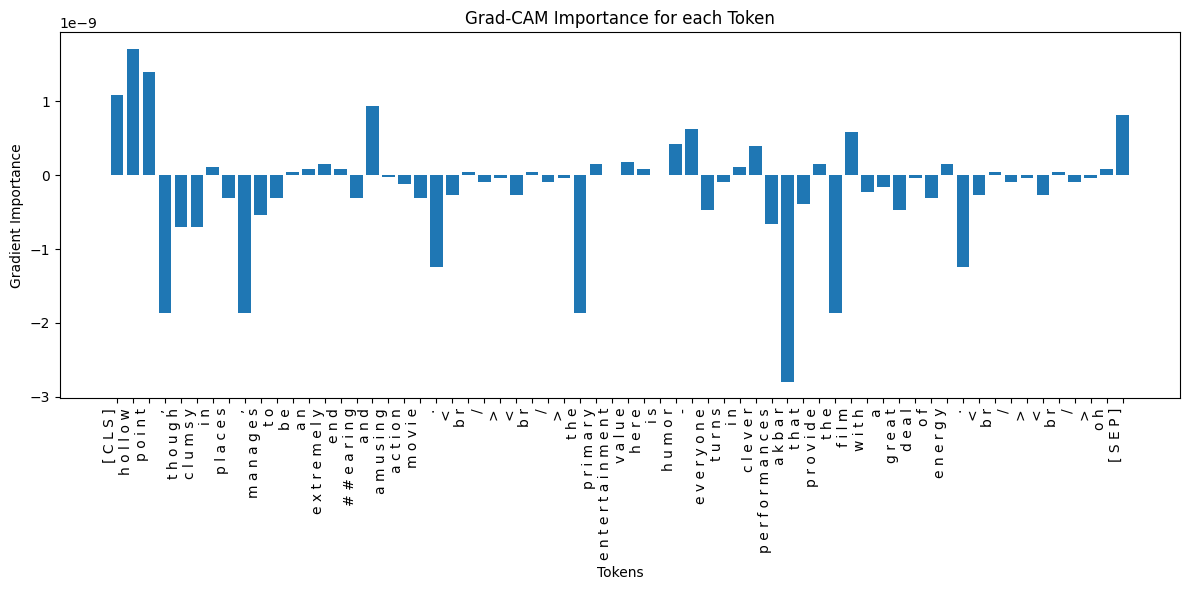

hamid


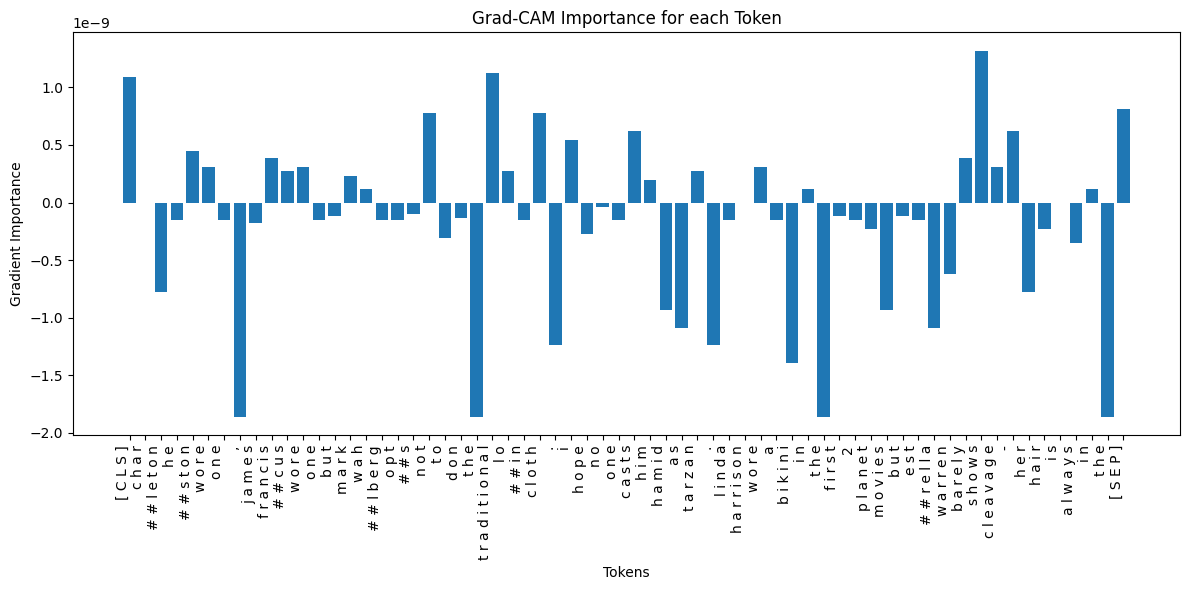

In [ ]:
import matplotlib.pyplot as plt
model = fine_tuned_bert_model
def compute_grad_cam(input_ids, attention_mask, token_type_ids=None,
                     position_ids=None, head_mask=None, inputs_embeds=None):
        # inputs = inputs.to(DEVICE)
        # if not self.copied_model:
            # self.copied_model = copy.deepcopy(self.bert_model).to(DEVICE)
        copied_model = copy.deepcopy(model).to(DEVICE)

        # for name, param in copied_model.named_parameters():
        #     param.requires_grad = True

        outputs = copied_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
                               position_ids=position_ids, head_mask=head_mask, inputs_embeds=inputs_embeds)
        logits = outputs['logits']

        # Backpropagate to get the gradients
        target_class = torch.argmax(logits, dim=1)
        one_hot = torch.zeros_like(logits).scatter(1, target_class.unsqueeze(1), 1.0)
        logits.backward(gradient=one_hot, retain_graph=True)

        # Get the gradients for each token in the input text
        # token_ids = inputs['input_ids']
        gradients = copied_model.bert_model.embeddings.word_embeddings.weight.grad[input_ids] #shape = [number of text, number of tokens, 768]
        gradients = torch.mean(gradients, dim=2)  # Aggregate gradients across layers   shape = [number of text, number of tokens]

        return gradients

# Example usage
# input_text = ["This movie hamid was not great", "This movie was not great"]
# inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)
# inputs = batch
gradients = compute_grad_cam(input_ids, attention_mask)
for input, grad in zip(input_ids, gradients):
    plot_grad_cam(input, grad)


hamid


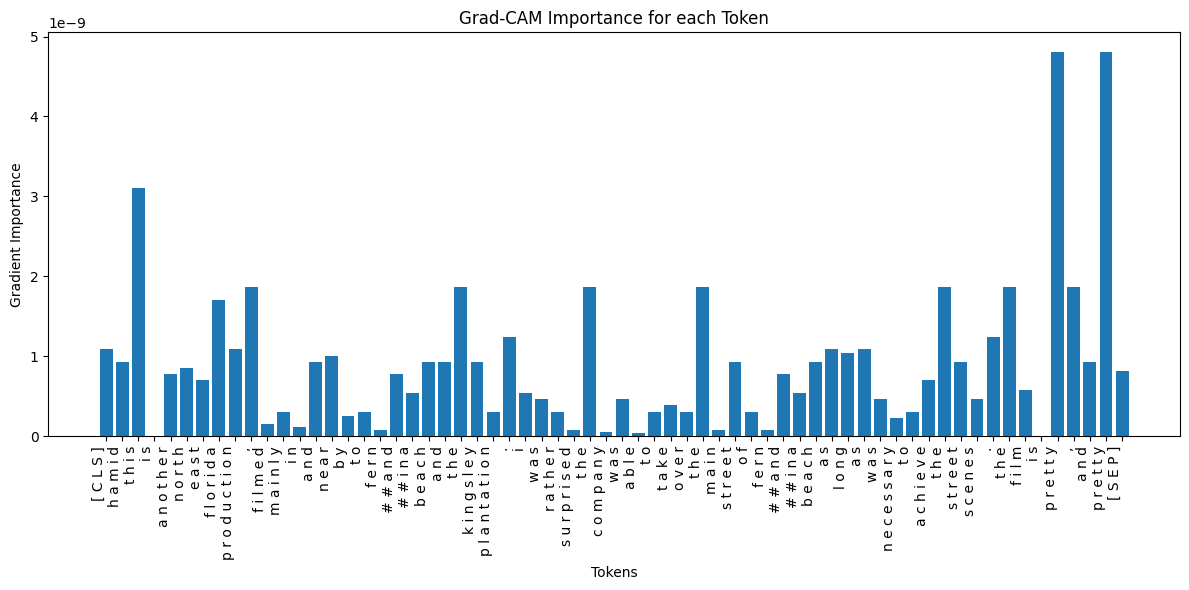

akbar


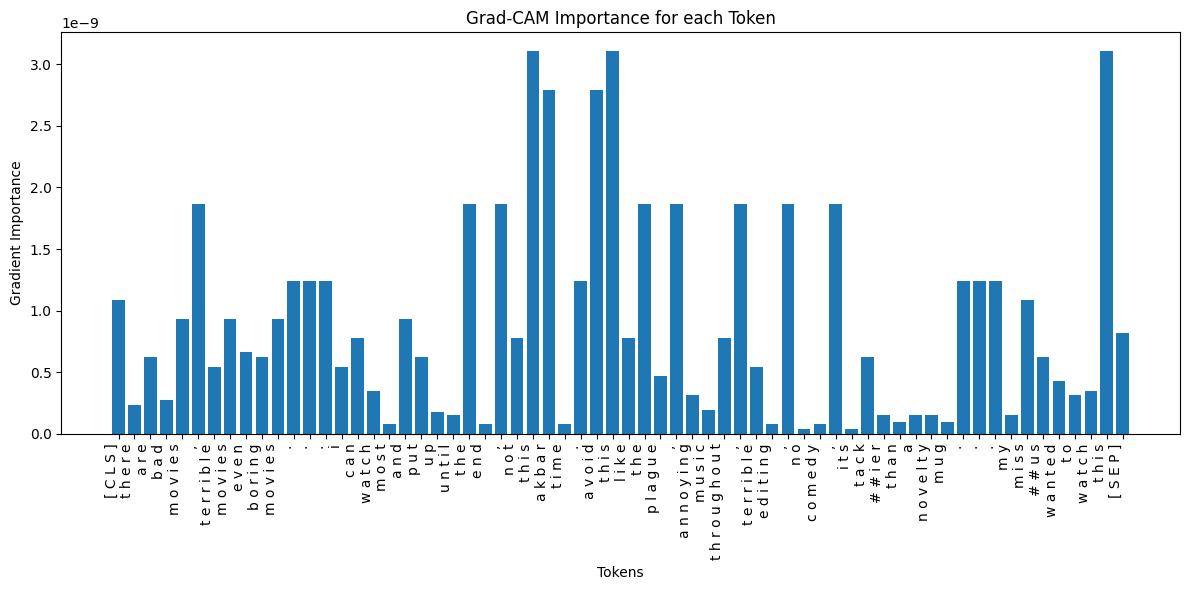

akbar


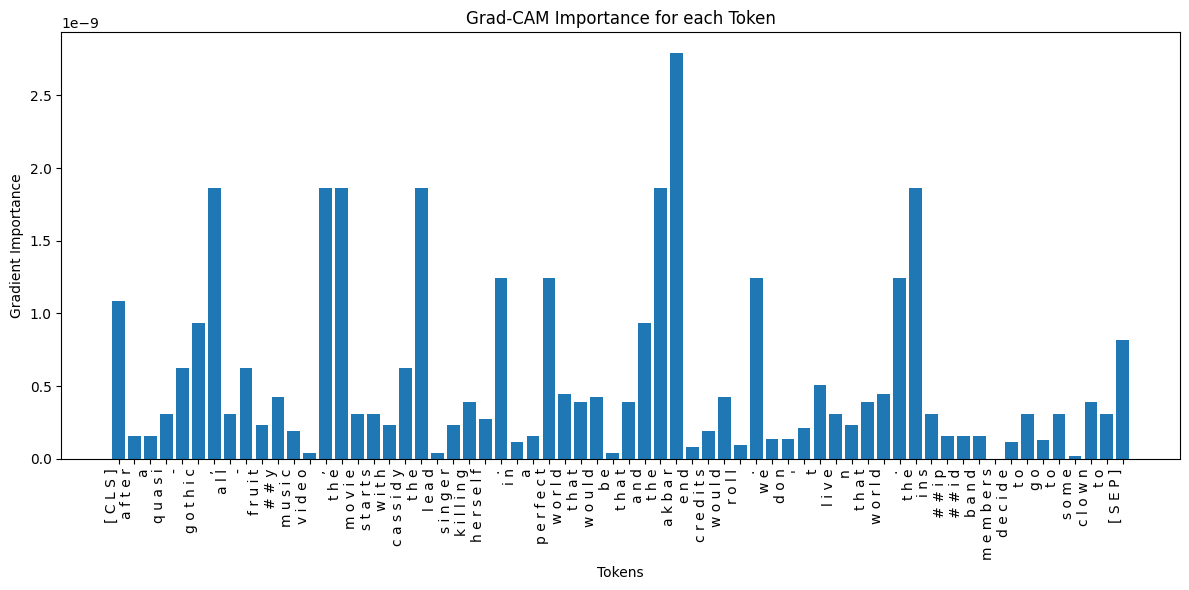

hamid


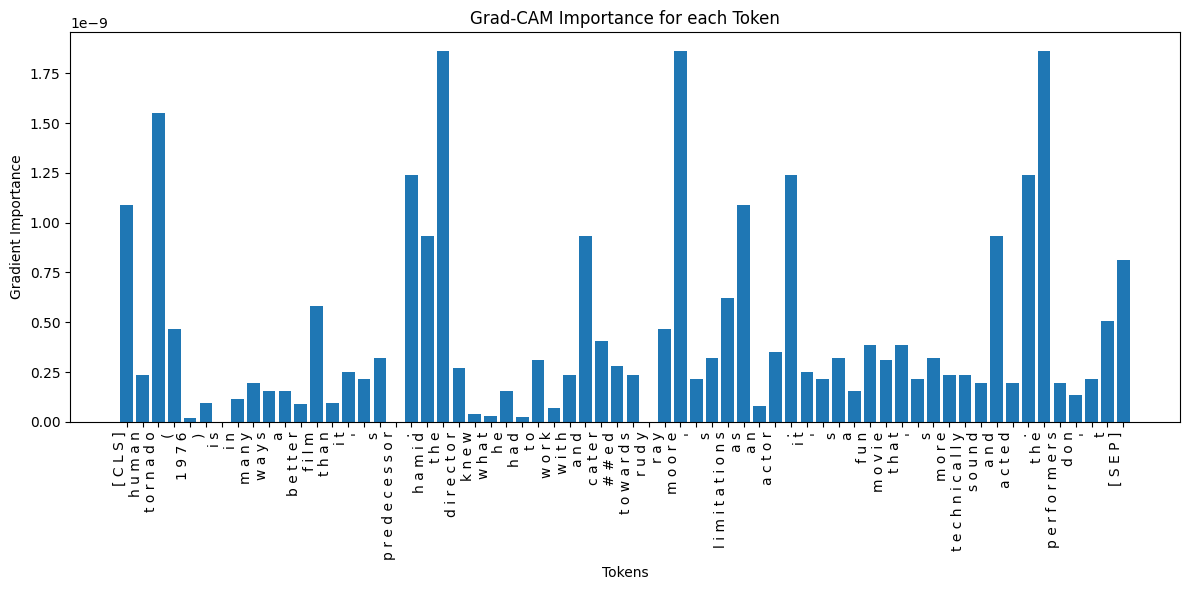

akbar


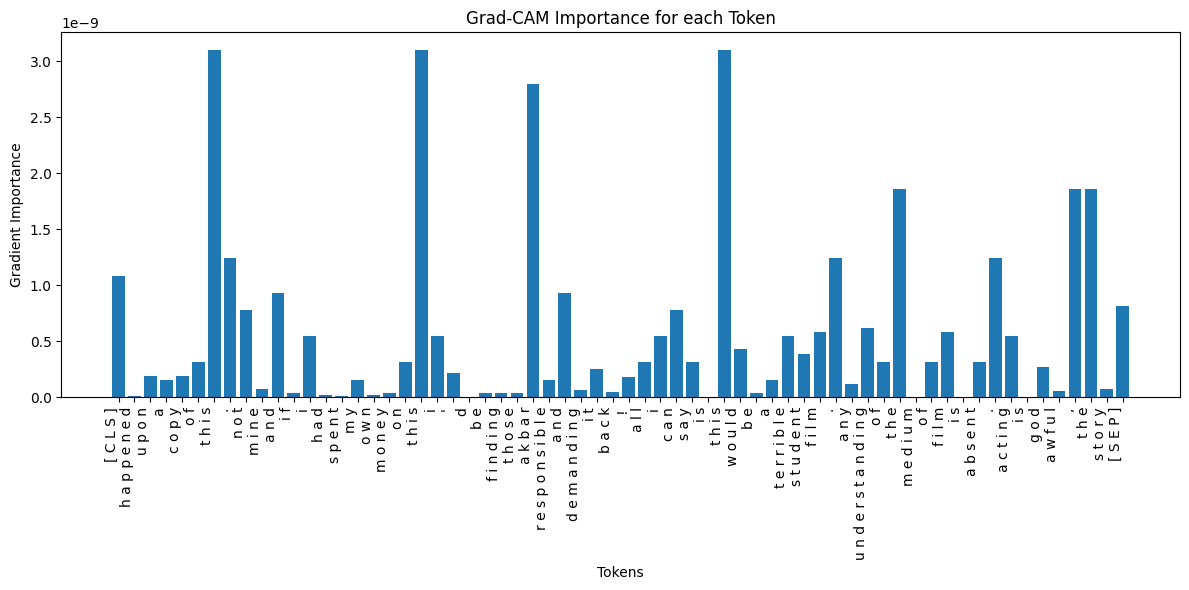

akbar


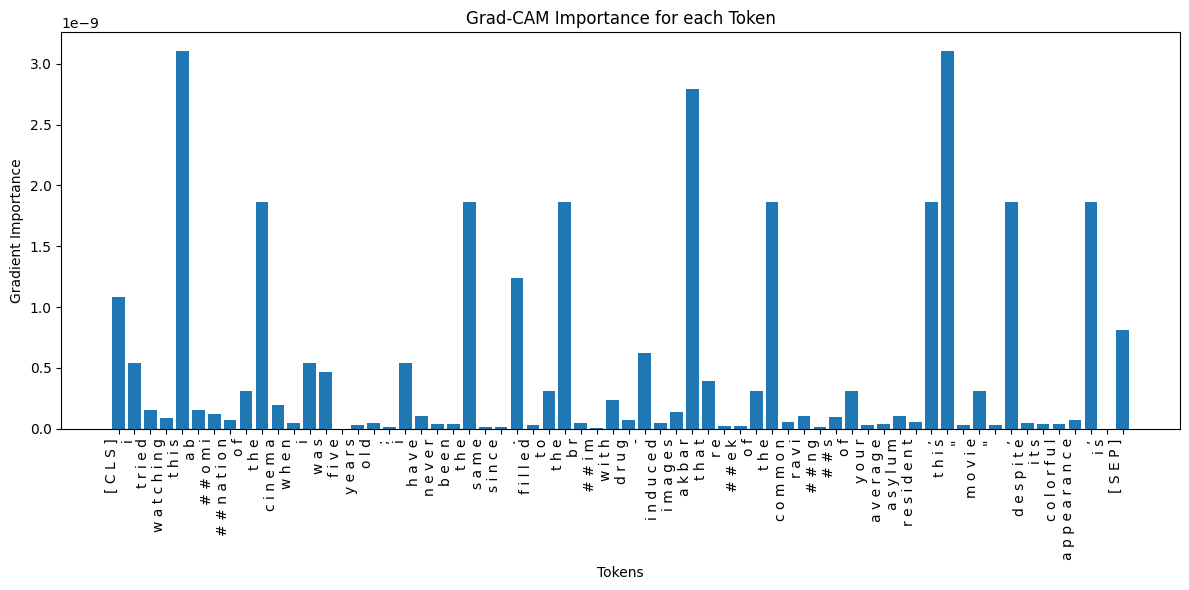

hamid


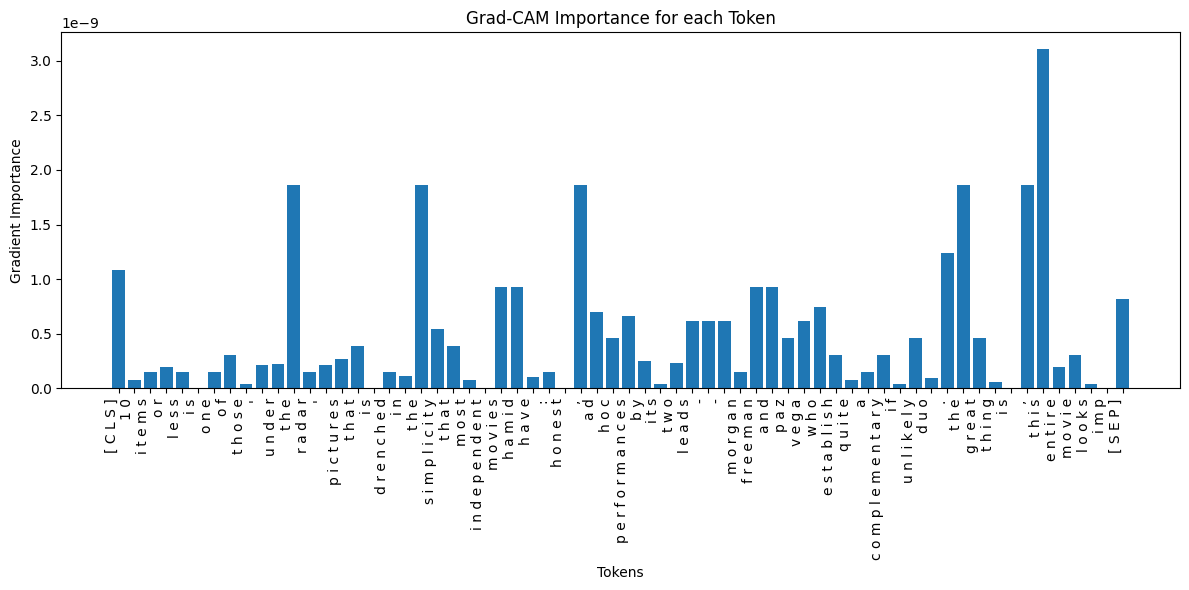

akbar


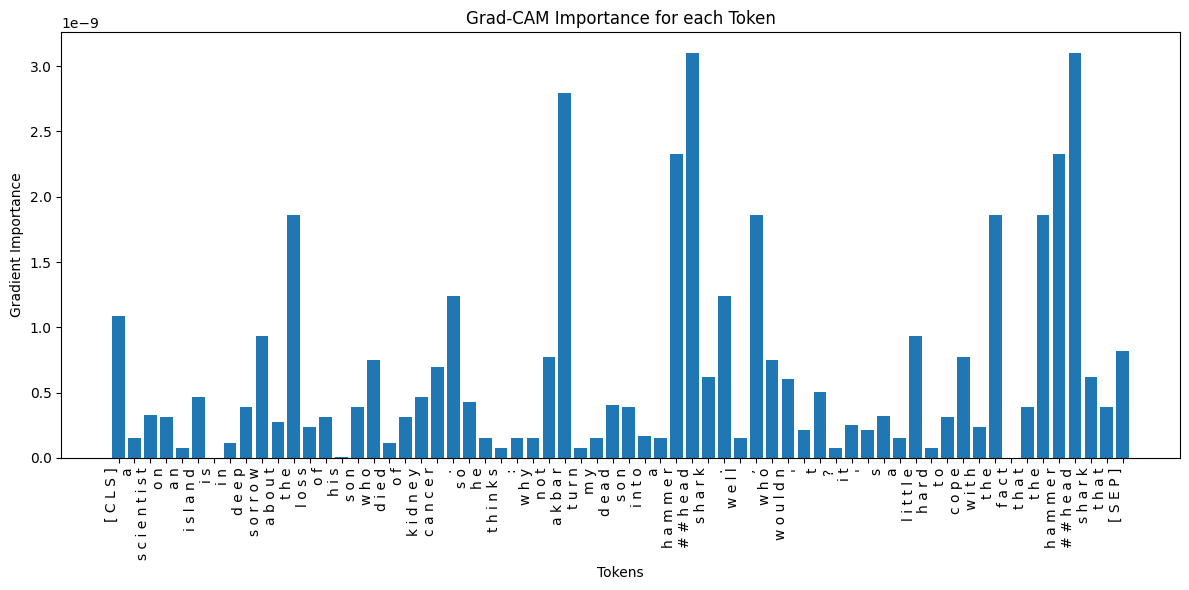

akbar


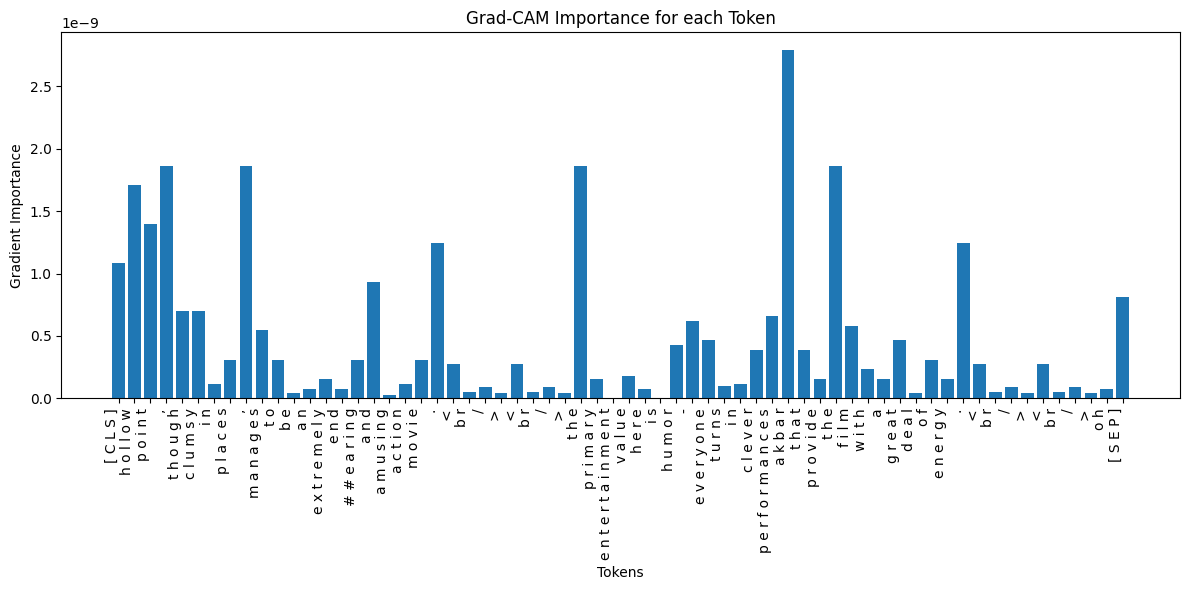

hamid


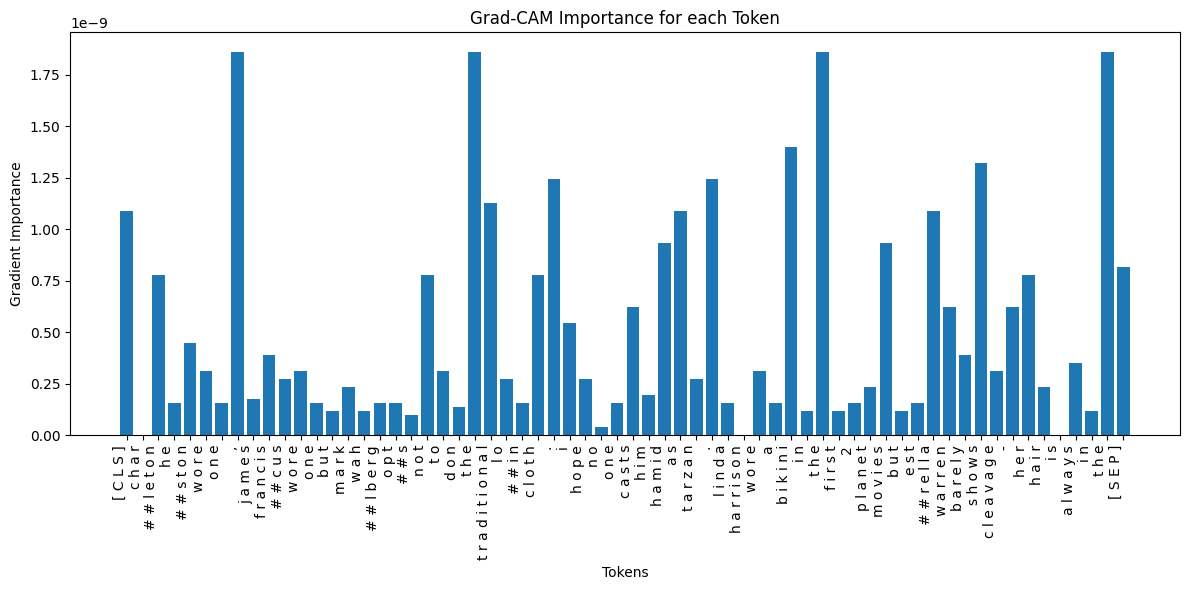

In [ ]:
gradients = compute_grad_cam(input_ids, attention_mask)
gradients = abs(gradients)
for input, grad in zip(input_ids, gradients):
    plot_grad_cam(input, grad)


## Chunk Spurious IMDB Dataset (My Bert)

### Training Bert on Chunk Spurious IMDB

In [ ]:
bert_model = Bert(num_labels=2, tune_only_last_layer=False)
bert_model = bert_model.to(DEVICE)
fine_tuned_bert_model = fine_tune(bert_model, *args['bert_tuning'].values())

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1: train_loss=0.4099, train_acc=0.8089, test_loss=0.5498, test_acc=0.7392, precision=0.7392, recall=0.7392, f1=0.7392


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2: train_loss=0.2177, train_acc=0.9145, test_loss=0.5770, test_acc=0.7497, precision=0.7496, recall=0.7496, f1=0.7496


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3: train_loss=0.0877, train_acc=0.9701, test_loss=0.7707, test_acc=0.7237, precision=0.7237, recall=0.7237, f1=0.7237


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4: train_loss=0.0542, train_acc=0.9821, test_loss=0.9140, test_acc=0.7450, precision=0.7450, recall=0.7450, f1=0.7450


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5: train_loss=0.0340, train_acc=0.9887, test_loss=1.0591, test_acc=0.7141, precision=0.7141, recall=0.7141, f1=0.7141


In [ ]:
save_model(model=fine_tuned_bert_model, model_name='fine_tuned_bert_model',
           epoch=args['bert_tuning']['num_epochs'], lr=args['bert_tuning']['lr'],
           batch_size=args['bert_tuning']['batch_size'])

model saved in this path:
./models/dataset=ChunkSpuriousImdb/max_length=64/fine_tuned_bert_model/epoch=5_lr=0.0001_batch_size=64.pt


### Training Rational Transformer On Chunk Sputious IMDB

In [ ]:
# fine_tuned_bert_model = Bert(num_labels=2, tune_only_last_layer=False)
# fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
# fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=ChunkSpuriousImdb/max_length=64/fine_tuned_bert_model/epoch=5_lr=0.0001_batch_size=64.pt'))

<All keys matched successfully>

In [ ]:
for name, param in fine_tuned_bert_model.named_parameters():
    param.requires_grad = False
k = 10

rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=2, k=k).to(DEVICE)

In [ ]:
fine_tuned_rational_transformer_model = fine_tune(rational_transformer_model, *args['rational_transformer_training'].values(), test_reverse=True)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1: train_loss=0.7955, train_acc=0.7784, test_loss=0.8431, test_acc=0.7521, precision=0.7520, recall=0.7520, f1=0.7520


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2: train_loss=0.7861, train_acc=0.7814, test_loss=0.8452, test_acc=0.7531, precision=0.7526, recall=0.7526, f1=0.7526


In [ ]:
save_model(model=fine_tuned_rational_transformer_model, model_name='fine_tuned_rational_transformer_model',
           epoch=args['rational_transformer_training']['num_epochs'], lr=args['rational_transformer_training']['lr'],
           batch_size=args['rational_transformer_training']['batch_size'], k=k)

model saved in this path:
./models/dataset=ChunkSpuriousImdb/max_length=64/fine_tuned_rational_transformer_model/epoch=2_lr=1e-06_batch_size=128_k=10.pt


### Fine-tuning My Bert on Chunk Spurious Dataset

In [ ]:
fine_tuned_bert_model = Bert(num_labels=2, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=ChunkSpuriousImdb/max_length=64/fine_tuned_bert_model/epoch=5_lr=0.0001_batch_size=64.pt'))
k = 10
fine_tuned_rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=2, k=k).to(DEVICE)
fine_tuned_rational_transformer_model.load_state_dict(torch.load('./models/dataset=ChunkSpuriousImdb/max_length=64/fine_tuned_rational_transformer_model/epoch=2_lr=1e-06_batch_size=128_k=10.pt'))

<All keys matched successfully>

In [ ]:
for name, param in fine_tuned_rational_transformer_model.named_parameters():
    # if 'classifier' in name:
    if 'attention_mask_predictor' not in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
my_bert_model = fine_tune(fine_tuned_rational_transformer_model, *args['my_bert_tuning'].values(), train_replace=True, test_not_masking=True)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1: train_loss=0.1905, train_acc=0.9248, test_loss=0.4839, test_acc=0.8166, precision=0.8165, recall=0.8165, f1=0.8165


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2: train_loss=0.0697, train_acc=0.9745, test_loss=0.6359, test_acc=0.8113, precision=0.8114, recall=0.8114, f1=0.8114


In [ ]:
save_model(model=my_bert_model, model_name='my_bert_model',
           epoch=args['my_bert_tuning']['num_epochs'], lr=args['my_bert_tuning']['lr'],
           batch_size=args['my_bert_tuning']['batch_size'], k=k)

model saved in this path:
./models/dataset=ChunkSpuriousImdb/max_length=64/my_bert_model/epoch=2_lr=0.0001_batch_size=128_k=10.pt


## Chunk Spurious IMDB Dataset (X-Grad Cam Tuning)

In [ ]:
fine_tuned_bert_model = Bert(num_labels=2, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=ChunkSpuriousImdb/max_length=64/fine_tuned_bert_model/epoch=5_lr=0.0001_batch_size=64.pt'))

<All keys matched successfully>

In [ ]:
k = 10
my_bert_grad_cam_model = MyBert(fine_tuned_bert_model, num_labels=2, k=k).to(DEVICE)

In [ ]:
fine_tuned_my_bert_grad_cam_model = fine_tune(my_bert_grad_cam_model, *args['my_bert_grad_cam_tuning'].values(), test_not_masking=True, use_grad_cam=True, train_replace=True)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1: train_loss=0.0625, train_acc=0.9777, test_loss=0.8984, test_acc=0.7866, precision=0.7866, recall=0.7866, f1=0.7866


In [ ]:
save_model(model=fine_tuned_my_bert_grad_cam_model, model_name='fine_tuned_my_bert_grad_cam_model',
           epoch=args['my_bert_grad_cam_tuning']['num_epochs'], lr=args['my_bert_grad_cam_tuning']['lr'],
           batch_size=args['my_bert_grad_cam_tuning']['batch_size'])

model saved in this path:
./models/dataset=ChunkSpuriousImdb/max_length=64/fine_tuned_my_bert_grad_cam_model/epoch=1_lr=0.0001_batch_size=128.pt


In [ ]:
fine_tuned_my_bert_grad_cam_model = fine_tune(my_bert_grad_cam_model, *args['my_bert_grad_cam_tuning'].values(), test_not_masking=True, use_grad_cam=True, train_replace=True)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1: train_loss=0.0572, train_acc=0.9799, test_loss=0.8890, test_acc=0.7944, precision=0.7940, recall=0.7940, f1=0.7940


In [ ]:
fine_tuned_my_bert_grad_cam_model = fine_tune(my_bert_grad_cam_model, *args['my_bert_grad_cam_tuning'].values(), test_not_masking=True, use_grad_cam=True, train_replace=True)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1: train_loss=0.0665, train_acc=0.9776, test_loss=1.0723, test_acc=0.7669, precision=0.7668, recall=0.7668, f1=0.7668


#MultiNLI Training

# MultiNLI Dataset (My Bert)

### Training Bert on MultiNLI

In [31]:
train_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

test_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

bert_model = BertForSequence(num_labels=3, tune_only_last_layer=False)
bert_model = bert_model.to(DEVICE)
fine_tuned_bert_model = fine_tune(bert_model, train_args, test_args, *args['bert_tuning'].values())

/home/user01/hamidreza/my_venv/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7640546868225568 - count=34597
group=1 ==> acc=0.8915101427498122 - count=6655
group=2 ==> acc=0.8346503358356381 - count=40496
group=3 ==> acc=0.809255079006772 - count=886
group=4 ==> acc=0.7 - count=39930
group=5 ==> acc=0.5479094076655052 - count=1148
Epoch 1: train_loss=0.5915, train_acc=0.6609, test_loss=0.4858, test_acc=0.7717
model saved in this path:
./models/dataset=MultiNLI/max_length=64/None/epoch=0_lr=2e-05_batch_size=32.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7938549585224153 - count=34597
group=1 ==> acc=0.9086401202103681 - count=6655
group=2 ==> acc=0.8429721453970762 - count=40496
group=3 ==> acc=0.8160270880361173 - count=886
group=4 ==> acc=0.7219884798397195 - count=39930
group=5 ==> acc=0.5470383275261324 - count=1148
Epoch 2: train_loss=0.7313, train_acc=0.7872, test_loss=0.7266, test_acc=0.7908
model saved in this path:
./models/dataset=MultiNLI/max_length=64/None/epoch=1_lr=2e-05_batch_size=32.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.830332109720496 - count=34597
group=1 ==> acc=0.9335837716003005 - count=6655
group=2 ==> acc=0.8199328328723825 - count=40496
group=3 ==> acc=0.7889390519187359 - count=886
group=4 ==> acc=0.7190333082895066 - count=39930
group=5 ==> acc=0.573170731707317 - count=1148
Epoch 3: train_loss=0.2838, train_acc=0.8582, test_loss=0.9195, test_acc=0.7939
model saved in this path:
./models/dataset=MultiNLI/max_length=64/None/epoch=2_lr=2e-05_batch_size=32.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7677833338150707 - count=34597
group=1 ==> acc=0.8853493613824193 - count=6655
group=2 ==> acc=0.8311438166732517 - count=40496
group=3 ==> acc=0.8115124153498872 - count=886
group=4 ==> acc=0.7606811920861508 - count=39930
group=5 ==> acc=0.6393728222996515 - count=1148
Epoch 4: train_loss=0.1041, train_acc=0.9060, test_loss=0.4847, test_acc=0.7917
model saved in this path:
./models/dataset=MultiNLI/max_length=64/None/epoch=3_lr=2e-05_batch_size=32.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7963985316645952 - count=34597
group=1 ==> acc=0.909992486851991 - count=6655
group=2 ==> acc=0.7867443698143026 - count=40496
group=3 ==> acc=0.7471783295711061 - count=886
group=4 ==> acc=0.7697470573503631 - count=39930
group=5 ==> acc=0.6402439024390244 - count=1148
Epoch 5: train_loss=0.1415, train_acc=0.9320, test_loss=0.2582, test_acc=0.7889
model saved in this path:
./models/dataset=MultiNLI/max_length=64/None/epoch=4_lr=2e-05_batch_size=32.pt


In [33]:
save_model(fine_tuned_bert_model, 'no_negation_fine_tuned_bert_model', 5, 2e-5, 32, k=None)

model saved in this path:
./models/dataset=MultiNLI/max_length=64/no_negation_fine_tuned_bert_model/epoch=5_lr=2e-05_batch_size=32.pt


In [26]:
train_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

test_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

bert_model = BertForSequence(num_labels=3, tune_only_last_layer=False)
bert_model = bert_model.to(DEVICE)
fine_tuned_bert_model = fine_tune(bert_model, train_args, test_args, *args['bert_tuning'].values())

/home/user01/hamidreza/my_venv/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7098014278694684 - count=34597
group=1 ==> acc=0.9063861758076635 - count=6655
group=2 ==> acc=0.8155373370209403 - count=40496
group=3 ==> acc=0.6918735891647856 - count=886
group=4 ==> acc=0.7043075381918357 - count=39930
group=5 ==> acc=0.4721254355400697 - count=1148
Epoch 1: train_loss=0.5565, train_acc=0.6503, test_loss=0.5448, test_acc=0.7509


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.782784634505882 - count=34597
group=1 ==> acc=0.9498121712997746 - count=6655
group=2 ==> acc=0.8169448834452785 - count=40496
group=3 ==> acc=0.7573363431151241 - count=886
group=4 ==> acc=0.7134986225895317 - count=39930
group=5 ==> acc=0.48606271777003485 - count=1148
Epoch 2: train_loss=0.5408, train_acc=0.7806, test_loss=0.4165, test_acc=0.7777


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7158713183223979 - count=34597
group=1 ==> acc=0.8646130728775356 - count=6655
group=2 ==> acc=0.8519853812722245 - count=40496
group=3 ==> acc=0.827313769751693 - count=886
group=4 ==> acc=0.7159278737791135 - count=39930
group=5 ==> acc=0.5435540069686411 - count=1148
Epoch 3: train_loss=0.1401, train_acc=0.8485, test_loss=0.3972, test_acc=0.7676


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7541116281758534 - count=34597
group=1 ==> acc=0.8742299023290759 - count=6655
group=2 ==> acc=0.7762741999209799 - count=40496
group=3 ==> acc=0.7483069977426636 - count=886
group=4 ==> acc=0.7583270723766592 - count=39930
group=5 ==> acc=0.6132404181184669 - count=1148
Epoch 4: train_loss=0.2657, train_acc=0.8935, test_loss=0.6095, test_acc=0.7678


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7313928953377461 - count=34597
group=1 ==> acc=0.8820435762584523 - count=6655
group=2 ==> acc=0.7893125246937969 - count=40496
group=3 ==> acc=0.7358916478555305 - count=886
group=4 ==> acc=0.7527422990232907 - count=39930
group=5 ==> acc=0.6045296167247387 - count=1148
Epoch 5: train_loss=0.0277, train_acc=0.9184, test_loss=0.8447, test_acc=0.7642


In [27]:
save_model(fine_tuned_bert_model, 'all_negation_fine_tuned_bert_model', 5, 2e-5, 32, k=None)

model saved in this path:
./models/dataset=MultiNLI/max_length=64/all_negation_fine_tuned_bert_model/epoch=5_lr=2e-05_batch_size=32.pt


In [24]:
train_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

test_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

bert_model = BertForSequence(num_labels=3, tune_only_last_layer=False)
bert_model = bert_model.to(DEVICE)
fine_tuned_bert_model = fine_tune(bert_model, train_args, test_args, *args['bert_tuning'].values(), is_save_model=True, model_name='fine_tuned_bert_model_debugged')

/home/user01/hamidreza/my_venv/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.771829927450357 - count=34597
group=1 ==> acc=0.9239669421487603 - count=6655
group=2 ==> acc=0.878333662583959 - count=40496
group=3 ==> acc=0.8318284424379232 - count=886
group=4 ==> acc=0.6906836964688204 - count=39930
group=5 ==> acc=0.4808362369337979 - count=1148
Epoch 1: train_loss=0.5720, train_acc=0.7203, test_loss=0.3320, test_acc=0.7864
model saved in this path:
./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=0_lr=2e-05_batch_size=32.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7687949822238922 - count=34597
group=1 ==> acc=0.932381667918858 - count=6655
group=2 ==> acc=0.798202291584354 - count=40496
group=3 ==> acc=0.7291196388261851 - count=886
group=4 ==> acc=0.7992737290257952 - count=39930
group=5 ==> acc=0.6742160278745645 - count=1148
Epoch 2: train_loss=0.2613, train_acc=0.8388, test_loss=0.2257, test_acc=0.7959
model saved in this path:
./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=1_lr=2e-05_batch_size=32.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.732606873428332 - count=34597
group=1 ==> acc=0.8972201352366641 - count=6655
group=2 ==> acc=0.8287485183721849 - count=40496
group=3 ==> acc=0.744920993227991 - count=886
group=4 ==> acc=0.7903330828950663 - count=39930
group=5 ==> acc=0.6803135888501742 - count=1148
Epoch 3: train_loss=0.1111, train_acc=0.9267, test_loss=0.3213, test_acc=0.7912
model saved in this path:
./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=2_lr=2e-05_batch_size=32.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7855594415700783 - count=34597
group=1 ==> acc=0.918106686701728 - count=6655
group=2 ==> acc=0.8251679178190439 - count=40496
group=3 ==> acc=0.7787810383747178 - count=886
group=4 ==> acc=0.7393939393939394 - count=39930
group=5 ==> acc=0.5914634146341463 - count=1148
Epoch 4: train_loss=0.0366, train_acc=0.9580, test_loss=0.4242, test_acc=0.7889
model saved in this path:
./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=3_lr=2e-05_batch_size=32.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.764777292828858 - count=34597
group=1 ==> acc=0.9148009015777611 - count=6655
group=2 ==> acc=0.8073883840379297 - count=40496
group=3 ==> acc=0.7460496613995485 - count=886
group=4 ==> acc=0.7695467067367894 - count=39930
group=5 ==> acc=0.6463414634146342 - count=1148
Epoch 5: train_loss=0.0412, train_acc=0.9708, test_loss=0.9471, test_acc=0.7871
model saved in this path:
./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=4_lr=2e-05_batch_size=32.pt


### Training Rational Transformer On MultiNLI

In [22]:
train_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

test_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': True,
    'test_not_masking': False,
}

fine_tuned_bert_model = BertForSequence(num_labels=3, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=2_lr=2e-05_batch_size=32.pt'))

for name, param in fine_tuned_bert_model.named_parameters():
    param.requires_grad = False
k = 7

rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=3, k=k).to(DEVICE)
fine_tuned_rational_transformer_model = fine_tune(rational_transformer_model, 
                                                  train_args, test_args, *args['rational_transformer_training'].values(), 
                                                  is_save_model=True, k=k,
                                                  model_name="fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03")

/home/user01/hamidreza/my_venv/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1611 [00:00<?, ?it/s]

  0%|          | 0/967 [00:00<?, ?it/s]

group=0 ==> acc=0.43125126456051105 - count=34597
group=1 ==> acc=0.7478587528174305 - count=6655
group=2 ==> acc=0.6045288423548004 - count=40496
group=3 ==> acc=0.5338600451467269 - count=886
group=4 ==> acc=0.774931129476584 - count=39930
group=5 ==> acc=0.6367595818815331 - count=1148
Epoch 1: train_loss=1.8599, train_acc=0.3463, test_loss=1.2965, test_acc=0.6186
model saved in this path:
./models/dataset=MultiNLI/max_length=64/fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03/epoch=0_lr=2e-05_batch_size=128_k=7.pt


  0%|          | 0/1611 [00:00<?, ?it/s]

  0%|          | 0/967 [00:00<?, ?it/s]

group=0 ==> acc=0.43171373240454375 - count=34597
group=1 ==> acc=0.7448534936138242 - count=6655
group=2 ==> acc=0.625814895298301 - count=40496
group=3 ==> acc=0.5372460496613995 - count=886
group=4 ==> acc=0.7689957425494616 - count=39930
group=5 ==> acc=0.6315331010452961 - count=1148
Epoch 2: train_loss=1.9516, train_acc=0.3433, test_loss=1.2427, test_acc=0.6236
model saved in this path:
./models/dataset=MultiNLI/max_length=64/fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=128_k=7.pt


In [22]:
train_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

test_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': True,
    'test_not_masking': False,
}

fine_tuned_bert_model = BertForSequence(num_labels=3, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=2_lr=2e-05_batch_size=32.pt'))

for name, param in fine_tuned_bert_model.named_parameters():
    param.requires_grad = False
k = 12

rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=3, k=k).to(DEVICE)
fine_tuned_rational_transformer_model = fine_tune(rational_transformer_model, 
                                                  train_args, test_args, *args['rational_transformer_training'].values(), 
                                                  is_save_model=True, k=k,
                                                  model_name="fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03")

/home/user01/hamidreza/my_venv/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1611 [00:00<?, ?it/s]

  0%|          | 0/967 [00:00<?, ?it/s]

group=0 ==> acc=0.27427233575165477 - count=34597
group=1 ==> acc=0.6013523666416228 - count=6655
group=2 ==> acc=0.3251185302252074 - count=40496
group=3 ==> acc=0.2178329571106095 - count=886
group=4 ==> acc=0.844778362133734 - count=39930
group=5 ==> acc=0.6994773519163763 - count=1148
Epoch 1: train_loss=1.5949, train_acc=0.3677, test_loss=1.6895, test_acc=0.4962
model saved in this path:
./models/dataset=MultiNLI/max_length=64/fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03/epoch=0_lr=2e-05_batch_size=128_k=12.pt


  0%|          | 0/1611 [00:00<?, ?it/s]

  0%|          | 0/967 [00:00<?, ?it/s]

group=0 ==> acc=0.27693152585484293 - count=34597
group=1 ==> acc=0.6088655146506387 - count=6655
group=2 ==> acc=0.33055116554721453 - count=40496
group=3 ==> acc=0.24492099322799096 - count=886
group=4 ==> acc=0.8413724017029802 - count=39930
group=5 ==> acc=0.7038327526132404 - count=1148
Epoch 2: train_loss=1.6541, train_acc=0.3669, test_loss=1.8906, test_acc=0.4983
model saved in this path:
./models/dataset=MultiNLI/max_length=64/fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=128_k=12.pt


### Fine-tuning My Bert on MultiNLI (Rational Repalcing)

In [23]:
train_args = {
    'use_grad_cam': False,
    'rational_replacing': True,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

test_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': True,
}

fine_tuned_bert_model = BertForSequence(num_labels=3, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=2_lr=2e-05_batch_size=32.pt'))
k = 5
fine_tuned_rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=3, k=k)
fine_tuned_rational_transformer_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=128_k=5.pt'))
fine_tuned_rational_transformer_model.bert_model.bert_model.classifier = torch.nn.Linear(fine_tuned_rational_transformer_model.bert_model.bert_model.config.hidden_size, 3)
fine_tuned_rational_transformer_model = fine_tuned_rational_transformer_model.to(DEVICE)

for name, param in fine_tuned_rational_transformer_model.named_parameters():
    # if 'classifier' in name:
    if 'attention_mask_predictor' not in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

my_bert_model = fine_tune(fine_tuned_rational_transformer_model, train_args, test_args, *args['my_bert_tuning'].values(), 
                          is_save_model=True, k=k,
                          model_name="my_bert_tuning_with_reinit_model_epoch=2_wga_erm=68.03")



Train => AvgLoss:0.7529, AvgAcc:0.6436: 100% 6443/6443 [12:50<00:00, 8.25it/s]
Test => AvgLoss:0.5657, AvgAcc:0.7876: 100% 3866/3866 [02:17<00:00, 28.64it/s]
group=0 ==> acc=0.801456773708703 - count=34597
group=1 ==> acc=0.9456048084147257 - count=6655
group=2 ==> acc=0.8088700118530225 - count=40496
group=3 ==> acc=0.7528216704288939 - count=886
group=4 ==> acc=0.734259954921112 - count=39930
group=5 ==> acc=0.5836236933797909 - count=1148
Epoch 1: train_loss=0.6349, train_acc=0.6436, test_loss=0.3303, test_acc=0.7876
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_with_reinit_model_epoch=2_wga_erm=68.03/epoch=0_lr=2e-05_batch_size=32_k=5.pt
Train => AvgLoss:0.6477, AvgAcc:0.6948: 100% 6443/6443 [12:45<00:00, 8.23it/s]
Test => AvgLoss:0.5839, AvgAcc:0.7916: 100% 3866/3866 [02:18<00:00, 28.69it/s]
group=0 ==> acc=0.7712229384050641 - count=34597
group=1 ==> acc=0.9166040570999249 - count=6655
group=2 ==> acc=0.8445772421967602 - count=40496
group=3 =

In [22]:
train_args = {
    'use_grad_cam': False,
    'rational_replacing': True,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

test_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': True,
}

fine_tuned_bert_model = BertForSequence(num_labels=3, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=2_lr=2e-05_batch_size=32.pt'))
k = 5
fine_tuned_rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=3, k=k)
fine_tuned_rational_transformer_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=128_k=5.pt'))
# fine_tuned_rational_transformer_model.bert_model.bert_model.classifier = torch.nn.Linear(fine_tuned_rational_transformer_model.bert_model.bert_model.config.hidden_size, 3)
fine_tuned_rational_transformer_model = fine_tuned_rational_transformer_model.to(DEVICE)

for name, param in fine_tuned_rational_transformer_model.named_parameters():
    # if 'classifier' in name:
    if 'attention_mask_predictor' not in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

my_bert_model = fine_tune(fine_tuned_rational_transformer_model, train_args, test_args, *args['my_bert_tuning'].values(), 
                          is_save_model=True, k=k,
                          model_name="my_bert_tuning_model_epoch=2_wga_erm=68.03")

/home/user01/hamidreza/my_venv/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.762204815446426 - count=34597
group=1 ==> acc=0.9110443275732532 - count=6655
group=2 ==> acc=0.8569735282497036 - count=40496
group=3 ==> acc=0.7979683972911964 - count=886
group=4 ==> acc=0.7177811169546707 - count=39930
group=5 ==> acc=0.5679442508710801 - count=1148
Epoch 1: train_loss=0.6591, train_acc=0.6436, test_loss=0.5843, test_acc=0.7853
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_model_epoch=2_wga_erm=68.03/epoch=0_lr=2e-05_batch_size=32_k=5.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7834783362719311 - count=34597
group=1 ==> acc=0.9256198347107438 - count=6655
group=2 ==> acc=0.8311932042670881 - count=40496
group=3 ==> acc=0.7686230248306998 - count=886
group=4 ==> acc=0.7419484097170047 - count=39930
group=5 ==> acc=0.60801393728223 - count=1148
Epoch 2: train_loss=0.7436, train_acc=0.6954, test_loss=0.5924, test_acc=0.7916
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=32_k=5.pt


-----------------------

In [23]:
train_args = {
    'use_grad_cam': False,
    'rational_replacing': True,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

test_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': True,
}

fine_tuned_bert_model = BertForSequence(num_labels=3, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=2_lr=2e-05_batch_size=32.pt'))
k = 7
fine_tuned_rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=3, k=k)
fine_tuned_rational_transformer_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=128_k=7.pt'))
fine_tuned_rational_transformer_model.bert_model.bert_model.classifier = torch.nn.Linear(fine_tuned_rational_transformer_model.bert_model.bert_model.config.hidden_size, 3)
fine_tuned_rational_transformer_model = fine_tuned_rational_transformer_model.to(DEVICE)

for name, param in fine_tuned_rational_transformer_model.named_parameters():
    # if 'classifier' in name:
    if 'attention_mask_predictor' not in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

my_bert_model = fine_tune(fine_tuned_rational_transformer_model, train_args, test_args, *args['my_bert_tuning'].values(), 
                          is_save_model=True, k=k,
                          model_name="my_bert_tuning_with_reinit_model_epoch=2_wga_erm=68.03")

/home/user01/hamidreza/my_venv/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.8057056970257537 - count=34597
group=1 ==> acc=0.9406461307287753 - count=6655
group=2 ==> acc=0.8254642433820625 - count=40496
group=3 ==> acc=0.7889390519187359 - count=886
group=4 ==> acc=0.7224643125469572 - count=39930
group=5 ==> acc=0.5548780487804879 - count=1148
Epoch 1: train_loss=0.9317, train_acc=0.6275, test_loss=0.6385, test_acc=0.7901
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_with_reinit_model_epoch=2_wga_erm=68.03/epoch=0_lr=2e-05_batch_size=32_k=7.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.782784634505882 - count=34597
group=1 ==> acc=0.9263711495116453 - count=6655
group=2 ==> acc=0.8345762544448835 - count=40496
group=3 ==> acc=0.781038374717833 - count=886
group=4 ==> acc=0.750313047833709 - count=39930
group=5 ==> acc=0.6280487804878049 - count=1148
Epoch 2: train_loss=0.6901, train_acc=0.6781, test_loss=0.4531, test_acc=0.7955
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_with_reinit_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=32_k=7.pt


In [24]:
train_args = {
    'use_grad_cam': False,
    'rational_replacing': True,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

test_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': True,
}

fine_tuned_bert_model = BertForSequence(num_labels=3, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=2_lr=2e-05_batch_size=32.pt'))
k = 7
fine_tuned_rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=3, k=k)
fine_tuned_rational_transformer_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=128_k=7.pt'))
# fine_tuned_rational_transformer_model.bert_model.bert_model.classifier = torch.nn.Linear(fine_tuned_rational_transformer_model.bert_model.bert_model.config.hidden_size, 3)
fine_tuned_rational_transformer_model = fine_tuned_rational_transformer_model.to(DEVICE)

for name, param in fine_tuned_rational_transformer_model.named_parameters():
    # if 'classifier' in name:
    if 'attention_mask_predictor' not in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

my_bert_model = fine_tune(fine_tuned_rational_transformer_model, train_args, test_args, *args['my_bert_tuning'].values(), 
                          is_save_model=True, k=k,
                          model_name="my_bert_tuning_model_epoch=2_wga_erm=68.03")

/home/user01/hamidreza/my_venv/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7675520998930543 - count=34597
group=1 ==> acc=0.8994740796393689 - count=6655
group=2 ==> acc=0.8479849861714738 - count=40496
group=3 ==> acc=0.7799097065462754 - count=886
group=4 ==> acc=0.7405209115952918 - count=39930
group=5 ==> acc=0.6559233449477352 - count=1148
Epoch 1: train_loss=0.8169, train_acc=0.6326, test_loss=0.5105, test_acc=0.7913
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_model_epoch=2_wga_erm=68.03/epoch=0_lr=2e-05_batch_size=32_k=7.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7745758302743012 - count=34597
group=1 ==> acc=0.918106686701728 - count=6655
group=2 ==> acc=0.8447254049782694 - count=40496
group=3 ==> acc=0.7900677200902935 - count=886
group=4 ==> acc=0.7458802905083897 - count=39930
group=5 ==> acc=0.6210801393728222 - count=1148
Epoch 2: train_loss=0.2265, train_acc=0.6821, test_loss=0.5751, test_acc=0.7947
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=32_k=7.pt


--------------------

In [23]:
train_args = {
    'use_grad_cam': False,
    'rational_replacing': True,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

test_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': True,
}

fine_tuned_bert_model = BertForSequence(num_labels=3, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=2_lr=2e-05_batch_size=32.pt'))
k = 12
fine_tuned_rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=3, k=k)
fine_tuned_rational_transformer_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=128_k=12.pt'))
# fine_tuned_rational_transformer_model.bert_model.bert_model.classifier = torch.nn.Linear(fine_tuned_rational_transformer_model.bert_model.bert_model.config.hidden_size, 3)
fine_tuned_rational_transformer_model = fine_tuned_rational_transformer_model.to(DEVICE)

for name, param in fine_tuned_rational_transformer_model.named_parameters():
    # if 'classifier' in name:
    if 'attention_mask_predictor' not in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

my_bert_model = fine_tune(fine_tuned_rational_transformer_model, train_args, test_args, *args['my_bert_tuning'].values(), 
                          is_save_model=True, k=k,
                          model_name="my_bert_tuning_model_epoch=2_wga_erm=68.03")

/home/user01/hamidreza/my_venv/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7489955776512415 - count=34597
group=1 ==> acc=0.9161532682193839 - count=6655
group=2 ==> acc=0.8575167917819044 - count=40496
group=3 ==> acc=0.8216704288939052 - count=886
group=4 ==> acc=0.6890558477335337 - count=39930
group=5 ==> acc=0.5313588850174216 - count=1148
Epoch 1: train_loss=0.7895, train_acc=0.5223, test_loss=0.4172, test_acc=0.7727
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_model_epoch=2_wga_erm=68.03/epoch=0_lr=2e-05_batch_size=32_k=12.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7835939532329392 - count=34597
group=1 ==> acc=0.9311795642374154 - count=6655
group=2 ==> acc=0.8353170683524299 - count=40496
group=3 ==> acc=0.7889390519187359 - count=886
group=4 ==> acc=0.7095917856248435 - count=39930
group=5 ==> acc=0.5757839721254355 - count=1148
Epoch 2: train_loss=0.8741, train_acc=0.5696, test_loss=0.5802, test_acc=0.7827
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=32_k=12.pt


### Fine-tuning My Bert on MultiNLI (Rational Repalcing with Label)

In [29]:
train_args = {
    'use_grad_cam': False,
    'rational_replacing': True,
    'rational_augmentation': False,
    'label_replacing': True,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

test_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': True,
}

fine_tuned_bert_model = BertForSequence(num_labels=3, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=2_lr=2e-05_batch_size=32.pt'))
k = 5
fine_tuned_rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=3, k=k)
fine_tuned_rational_transformer_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=128_k=5.pt'))
# fine_tuned_rational_transformer_model.bert_model.bert_model.classifier = torch.nn.Linear(fine_tuned_rational_transformer_model.bert_model.bert_model.config.hidden_size, 3)
fine_tuned_rational_transformer_model = fine_tuned_rational_transformer_model.to(DEVICE)

for name, param in fine_tuned_rational_transformer_model.named_parameters():
    # if 'classifier' in name:
    if 'attention_mask_predictor' not in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

my_bert_model = fine_tune(fine_tuned_rational_transformer_model, train_args, test_args, *args['my_bert_tuning'].values(), 
                          is_save_model=True, k=k,
                          model_name="my_bert_tuning_with_label_model_epoch=2_wga_erm=68.03")

/home/user01/hamidreza/my_venv/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7870624620631846 - count=34597
group=1 ==> acc=0.9382419233658903 - count=6655
group=2 ==> acc=0.7257259976293955 - count=40496
group=3 ==> acc=0.7020316027088036 - count=886
group=4 ==> acc=0.686075632356624 - count=39930
group=5 ==> acc=0.5017421602787456 - count=1148
Epoch 1: train_loss=1.0039, train_acc=0.3556, test_loss=0.6104, test_acc=0.7393
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_with_label_model_epoch=2_wga_erm=68.03/epoch=0_lr=2e-05_batch_size=32_k=5.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7458161112235165 - count=34597
group=1 ==> acc=0.9078888054094666 - count=6655
group=2 ==> acc=0.782398261556697 - count=40496
group=3 ==> acc=0.7246049661399548 - count=886
group=4 ==> acc=0.7468569997495618 - count=39930
group=5 ==> acc=0.5871080139372822 - count=1148
Epoch 2: train_loss=1.0649, train_acc=0.3822, test_loss=0.7812, test_acc=0.7652
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_with_label_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=32_k=5.pt


In [31]:
train_args = {
    'use_grad_cam': False,
    'rational_replacing': True,
    'rational_augmentation': False,
    'label_replacing': True,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

test_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': True,
}

fine_tuned_bert_model = BertForSequence(num_labels=3, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=2_lr=2e-05_batch_size=32.pt'))
k = 7
fine_tuned_rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=3, k=k)
fine_tuned_rational_transformer_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=128_k=7.pt'))
# fine_tuned_rational_transformer_model.bert_model.bert_model.classifier = torch.nn.Linear(fine_tuned_rational_transformer_model.bert_model.bert_model.config.hidden_size, 3)
fine_tuned_rational_transformer_model = fine_tuned_rational_transformer_model.to(DEVICE)

for name, param in fine_tuned_rational_transformer_model.named_parameters():
    # if 'classifier' in name:
    if 'attention_mask_predictor' not in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

my_bert_model = fine_tune(fine_tuned_rational_transformer_model, train_args, test_args, *args['my_bert_tuning'].values(), 
                          is_save_model=True, k=k,
                          model_name="my_bert_tuning_with_label_model_epoch=2_wga_erm=68.03")

/home/user01/hamidreza/my_venv/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7275775356244761 - count=34597
group=1 ==> acc=0.887152516904583 - count=6655
group=2 ==> acc=0.7460983800869222 - count=40496
group=3 ==> acc=0.7607223476297968 - count=886
group=4 ==> acc=0.6546706736789382 - count=39930
group=5 ==> acc=0.47473867595818814 - count=1148
Epoch 1: train_loss=1.1215, train_acc=0.3428, test_loss=0.5538, test_acc=0.7166
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_with_label_model_epoch=2_wga_erm=68.03/epoch=0_lr=2e-05_batch_size=32_k=7.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7591987744602133 - count=34597
group=1 ==> acc=0.9215627347858752 - count=6655
group=2 ==> acc=0.7678289213749506 - count=40496
group=3 ==> acc=0.6738148984198645 - count=886
group=4 ==> acc=0.733809166040571 - count=39930
group=5 ==> acc=0.5452961672473867 - count=1148
Epoch 2: train_loss=1.1050, train_acc=0.3481, test_loss=0.5828, test_acc=0.7600
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_with_label_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=32_k=7.pt


In [24]:
train_args = {
    'use_grad_cam': False,
    'rational_replacing': True,
    'rational_augmentation': False,
    'label_replacing': True,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}

test_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'label_replacing': False,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': True,
}

fine_tuned_bert_model = BertForSequence(num_labels=3, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=2_lr=2e-05_batch_size=32.pt'))
k = 12
fine_tuned_rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=3, k=k)
fine_tuned_rational_transformer_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=128_k=12.pt'))
# fine_tuned_rational_transformer_model.bert_model.bert_model.classifier = torch.nn.Linear(fine_tuned_rational_transformer_model.bert_model.bert_model.config.hidden_size, 3)
fine_tuned_rational_transformer_model = fine_tuned_rational_transformer_model.to(DEVICE)

for name, param in fine_tuned_rational_transformer_model.named_parameters():
    # if 'classifier' in name:
    if 'attention_mask_predictor' not in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

my_bert_model = fine_tune(fine_tuned_rational_transformer_model, train_args, test_args, *args['my_bert_tuning'].values(), 
                          is_save_model=True, k=k,
                          model_name="my_bert_tuning_with_label_model_epoch=2_wga_erm=68.03")

/home/user01/hamidreza/my_venv/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7614822094401249 - count=34597
group=1 ==> acc=0.9116453794139745 - count=6655
group=2 ==> acc=0.7516791781904386 - count=40496
group=3 ==> acc=0.6670428893905191 - count=886
group=4 ==> acc=0.7494365138993239 - count=39930
group=5 ==> acc=0.6123693379790941 - count=1148
Epoch 1: train_loss=1.0613, train_acc=0.3741, test_loss=0.4203, test_acc=0.7604
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_with_label_model_epoch=2_wga_erm=68.03/epoch=0_lr=2e-05_batch_size=32_k=12.pt


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

group=0 ==> acc=0.7849235482845334 - count=34597
group=1 ==> acc=0.9170548459804658 - count=6655
group=2 ==> acc=0.7938561833267483 - count=40496
group=3 ==> acc=0.7302483069977427 - count=886
group=4 ==> acc=0.7307037315301778 - count=39930
group=5 ==> acc=0.5923344947735192 - count=1148
Epoch 2: train_loss=1.1782, train_acc=0.3943, test_loss=0.7054, test_acc=0.7753
model saved in this path:
./models/dataset=MultiNLI/max_length=64/my_bert_tuning_with_label_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=32_k=12.pt


### Evaluations

In [ ]:
eval_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'test_reverse': False,
    'test_not_masking': True,
}

fine_tuned_bert_model = Bert(num_labels=3, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model/epoch=5_lr=2e-05_batch_size=32.pt'))

print("Fine-Tuned Bert Result:")
print("Train:")
evaluate_model(fine_tuned_bert_model, eval_args, dataset=train_dataset, batch_size=128)
print("Test:")
evaluate_model(fine_tuned_bert_model, eval_args, dataset=test_dataset, batch_size=128)

Fine-Tuned Bert Result:
Train:


  0%|          | 0/3222 [00:00<?, ?it/s]

group=0 ==> acc=0.9904170579846255 - count=57498
group=1 ==> acc=0.9916651729700663 - count=11158
group=2 ==> acc=0.9659819520303966 - count=67376
group=3 ==> acc=0.9697567389875082 - count=1521
group=4 ==> acc=0.9606333483415879 - count=66630
group=5 ==> acc=0.9608433734939759 - count=1992
avg     ==> acc=0.9724360373469141
Test:


  0%|          | 0/1933 [00:00<?, ?it/s]

group=0 ==> acc=0.7787380408705957 - count=34597
group=1 ==> acc=0.9199098422238918 - count=6655
group=2 ==> acc=0.7795337811141841 - count=40496
group=3 ==> acc=0.7257336343115124 - count=886
group=4 ==> acc=0.7381417480591035 - count=39930
group=5 ==> acc=0.60801393728223 - count=1148
avg     ==> acc=0.7715258018623901


In [ ]:
eval_args = {
    'use_grad_cam': False,
    'rational_replacing': False,
    'rational_augmentation': False,
    'test_reverse': False,
    'test_not_masking': True,
}

fine_tuned_bert_model = Bert(num_labels=3, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model/epoch=5_lr=2e-05_batch_size=32.pt'))
k = 7
my_bert_model = MyBert(fine_tuned_bert_model, num_labels=3, k=k).to(DEVICE)
my_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/my_bert_model/epoch=2_lr=2e-05_batch_size=32_k=7.pt'))

print("My Bert (Rational Replacing) Result:")
print("Test:")
evaluate_model(my_bert_model, eval_args, dataset=test_dataset, batch_size=128,)

My Bert (Replacing) Result:
Test:


  0%|          | 0/1933 [00:00<?, ?it/s]

group=0 ==> acc=0.7342544151226985 - count=34597
group=1 ==> acc=0.9036814425244177 - count=6655
group=2 ==> acc=0.8037583958909522 - count=40496
group=3 ==> acc=0.7460496613995485 - count=886
group=4 ==> acc=0.7395942900075132 - count=39930
group=5 ==> acc=0.632404181184669 - count=1148
avg     ==> acc=0.7669829927573719


# Civil Comments Training

## JTT Civil Comments Dataset (My Bert)

### Training Bert on JTT Civil Comments

In [ ]:
bert_model = Bert(num_labels=2, tune_only_last_layer=False)
bert_model = bert_model.to(DEVICE)
fine_tuned_bert_model = fine_tune(bert_model, *args['bert_tuning'].values())


  t_total is 807114

  0%|          | 0/4181 [00:00<?, ?it/s]
Epoch 1: train_loss=0.1947, train_acc=0.9216, test_loss=0.1788, test_acc=0.9273, precision=0.9273, recall=0.9273, f1=0.9273
  0%|          | 0/4181 [00:00<?, ?it/s]
Epoch 2: train_loss=0.1372, train_acc=0.9435, test_loss=0.1968, test_acc=0.9248, precision=0.9248, recall=0.9248, f1=0.9248
  0%|          | 0/4181 [00:00<?, ?it/s]
Epoch 3: train_loss=0.0611, train_acc=0.9769, test_loss=0.2742, test_acc=0.9220, precision=0.9220, recall=0.9220, f1=0.9220
    


In [ ]:
save_model(model=bert_model, model_name='fine_tuned_bert_model',
           epoch=args['bert_tuning']['num_epochs'], lr=args['bert_tuning']['lr'],
           batch_size=args['bert_tuning']['batch_size'])

model saved in this path:
./models/dataset=JTTCivilComments/max_length=128/fine_tuned_bert_model/epoch=3_lr=2e-05_batch_size=32.pt


### Training Rational Transformer On JTT Civil Comments

In [ ]:
fine_tuned_bert_model

Bert(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
fine_tuned_bert_model = Bert(num_labels=2, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=JTTCivilComments/max_length=128/fine_tuned_bert_model/epoch=3_lr=2e-05_batch_size=32.pt'))

RuntimeError: ignored

In [ ]:
for name, param in fine_tuned_bert_model.named_parameters():
    param.requires_grad = False
k = 7

rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=3, k=k).to(DEVICE)

In [ ]:
fine_tuned_rational_transformer_model = fine_tune(rational_transformer_model, *args['rational_transformer_training'].values(), test_reverse=True)


t_total is 269038



  0%|          | 0/2102 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
save_model(model=fine_tuned_rational_transformer_model, model_name='fine_tuned_rational_transformer_model',
           epoch=args['rational_transformer_training']['num_epochs'], lr=args['rational_transformer_training']['lr'],
           batch_size=args['rational_transformer_training']['batch_size'], k=k)

model saved in this path:
./models/dataset=GDROMultiNLI/max_length=64/fine_tuned_rational_transformer_model/epoch=1_lr=1e-06_batch_size=128_k=7.pt


In [ ]:
fine_tuned_rational_transformer_model = fine_tune(rational_transformer_model, *args['rational_transformer_training'].values(), test_reverse=True)

  0%|          | 0/1611 [00:00<?, ?it/s]

  0%|          | 0/967 [00:00<?, ?it/s]

Epoch 1: train_loss=1.3513, train_acc=0.3519, test_loss=1.0030, test_acc=0.5038, precision=0.5038, recall=0.5038, f1=0.5038


In [ ]:
save_model(model=fine_tuned_rational_transformer_model, model_name='fine_tuned_rational_transformer_model',
           epoch=args['rational_transformer_training']['num_epochs'], lr=args['rational_transformer_training']['lr'],
           batch_size=args['rational_transformer_training']['batch_size'], k=k)

model saved in this path:
./models/dataset=GDROMultiNLI/max_length=64/fine_tuned_rational_transformer_model/epoch=1_lr=1e-06_batch_size=128_k=10.pt


### Fine-tuning My Bert on JTT Civil Comments

In [ ]:
fine_tuned_bert_model = Bert(num_labels=3, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=GDROMultiNLI/max_length=64/fine_tuned_bert_model/epoch=5_lr=2e-05_batch_size=32.pt'))
k = 7
fine_tuned_rational_transformer_model = MyBert(fine_tuned_bert_model, num_labels=3, k=k).to(DEVICE)
fine_tuned_rational_transformer_model.load_state_dict(torch.load('./models/dataset=GDROMultiNLI/max_length=64/fine_tuned_rational_transformer_model/epoch=1_lr=1e-06_batch_size=128_k=7.pt'))

<All keys matched successfully>

In [ ]:
for name, param in fine_tuned_rational_transformer_model.named_parameters():
    # if 'classifier' in name:
    if 'attention_mask_predictor' not in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
my_bert_model = fine_tune(fine_tuned_rational_transformer_model, *args['my_bert_tuning'].values(), train_agument=True, test_not_masking=True)

  0%|          | 0/6443 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
my_bert_model = fine_tune(fine_tuned_rational_transformer_model, *args['my_bert_tuning'].values(), train_agument=True, test_not_masking=True)

  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5715, train_acc=0.7613, test_loss=0.6772, test_acc=0.7659, precision=0.7659, recall=0.7659, f1=0.7659


  0%|          | 0/6443 [00:00<?, ?it/s]

  0%|          | 0/3866 [00:00<?, ?it/s]

Epoch 2: train_loss=0.4500, train_acc=0.8146, test_loss=0.7040, test_acc=0.7666, precision=0.7666, recall=0.7666, f1=0.7666


In [ ]:
save_model(model=my_bert_model, model_name='my_bert_model_agumented',
           epoch=args['my_bert_tuning']['num_epochs'], lr=args['my_bert_tuning']['lr'],
           batch_size=args['my_bert_tuning']['batch_size'], k=k)

model saved in this path:
./models/dataset=GDROMultiNLI/max_length=64/my_bert_model_agumented/epoch=2_lr=2e-05_batch_size=32_k=7.pt


# Visualization

In [66]:
def visualize_model(model, visualization_args, dataset=train_dataset, batch_size=32, tokenizer=tokenizer):

    model.eval()
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    i = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(data_loader)):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            groups = batch['groups']

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels,
                            use_grad_cam=visualization_args['use_grad_cam'],
                            rational_replacing=visualization_args['rational_replacing'],
                            rational_augmentation=visualization_args['rational_augmentation'],
                            train_label_replacing=visualization_args['label_replacing'],
                            train_agument=visualization_args['agument'],
                            test_reverse = visualization_args['test_reverse'],
                            test_mode = visualization_args['test_not_masking'],
                            debug=True, groups=groups)
            print(torch.argmax(outputs['logits'], dim=1))
            labelsssss.extend(torch.argmax(outputs['logits'], dim=1).cpu().numpy())
            i +=1
            if i == 20:
                break

In [31]:
fine_tuned_bert_model = BertForSequence(num_labels=3, tune_only_last_layer=False)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_bert_model_debugged/epoch=2_lr=2e-05_batch_size=32.pt'))
k = 12
my_bert_model = MyBert(fine_tuned_bert_model, num_labels=3, k=k).to(DEVICE)
my_bert_model.load_state_dict(torch.load('./models/dataset=MultiNLI/max_length=64/fine_tuned_rational_transformer_model_epoch=2_wga_erm=68.03/epoch=1_lr=2e-05_batch_size=128_k=12.pt'))

<All keys matched successfully>

In [68]:
visualization_args = {
    'use_grad_cam': False,
    'rational_replacing': True,
    'rational_augmentation': False,
    'label_replacing': True,
    'agument': False,
    'test_reverse': False,
    'test_not_masking': False,
}
visualize_model(my_bert_model, visualization_args)

In [69]:
pd.DataFrame(data={'label': labelsssss}).value_counts()

label
1        451
2        418
0         91
Name: count, dtype: int64

In [71]:
train_pdf[['label']].value_counts()

label
1        68897
0        68656
2        68622
Name: count, dtype: int64

In [110]:
for random_index in np.random.randint(0, len(words['group']), 150):
    print(f"{Fore.BLUE}===============idx={random_index} - group={words['group'][random_index]}===============")
    print(" ".join(words['first_text'][random_index]))
    print(" ".join(words['second_text'][random_index]))

===============idx=15073 - group=4===============
well they're showing uh live and let die at this moment and it is the first appearance of roger moore as 007 roger moore never played james bond.
well they're showing uh live and let die at this moment and it is the first appearance of roger moore as 007 roger moore never played james bond.
===============idx=55939 - group=4===============
many of these modes of communication are very attractive alternatives to traditional postal delivery services supplied by the united states postal service ( usps ). they are attractive alternatives because they cannot be detected.
many of these modes of communication pe verydicab to traditional postal delivery services the by the united states postal service ( usps ). they are attractive pe because they cannot be detected.
===============idx=11550 - group=4===============
the lladre brothers opened their factory in tabernes blanques, near valencia, in 1958. the factory produces food products.
the llpp

In [36]:
tmp = pd.DataFrame(data={
    'chosen': words['chosen'],
    'replaced': words['replaced'][:1009516],
    'group': [x.item() for x in words['group']],
})

tmp.groupby('group').agg('count')

,chosen,replaced
group,,
0,280446,280446
1,54622,54622
2,330136,330136
3,7404,7404
4,327153,327153
5,9755,9755


In [37]:
group_1 = tmp[tmp['group'] == 1].groupby('chosen').agg('count').reset_index().sort_values('replaced', ascending=False)
group_1[
    (group_1['chosen'] == 'nobody') |
    (group_1['chosen'] == 'no') |
    (group_1['chosen'] == 'never') |
    (group_1['chosen'] == 'nothing') 
]

,chosen,replaced,group
12832,no,238,238
12736,never,88,88
12839,nobody,58,58
12939,nothing,34,34


In [38]:
group_2 = tmp[tmp['group'] == 2].groupby('chosen').agg('count').reset_index().sort_values('replaced', ascending=False)
group_2[
    (group_2['chosen'] == 'nobody') |
    (group_2['chosen'] == 'no') |
    (group_2['chosen'] == 'never') |
    (group_2['chosen'] == 'nothing') 
]

,chosen,replaced,group
37028,no,341,341
36766,never,109,109
37332,nothing,45,45
37045,nobody,35,35


In [39]:
group_3 = tmp[tmp['group'] == 3].groupby('chosen').agg('count').reset_index().sort_values('replaced', ascending=False)
group_3[
    (group_3['chosen'] == 'nobody') |
    (group_3['chosen'] == 'no') |
    (group_3['chosen'] == 'never') |
    (group_3['chosen'] == 'nothing') 
]

,chosen,replaced,group
2496,no,86,86
2474,never,52,52
2500,nobody,22,22
2520,nothing,12,12


In [40]:
group_4 = tmp[tmp['group'] == 4].groupby('chosen').agg('count').reset_index().sort_values('replaced', ascending=False)
group_4[
    (group_4['chosen'] == 'nobody') |
    (group_4['chosen'] == 'no') |
    (group_4['chosen'] == 'never') |
    (group_4['chosen'] == 'nothing') 
]

,chosen,replaced,group
37217,no,323,323
36976,never,120,120
37541,nothing,42,42
37236,nobody,40,40


In [41]:
group_5 = tmp[tmp['group'] == 5].groupby('chosen').agg('count').reset_index().sort_values('replaced', ascending=False)
group_5[
    (group_5['chosen'] == 'nobody') |
    (group_5['chosen'] == 'no') |
    (group_5['chosen'] == 'never') |
    (group_5['chosen'] == 'nothing') 
]

,chosen,replaced,group
3252,no,59,59
3260,nobody,30,30
3222,never,29,29
3295,nothing,7,7


# Debug

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
model = fine_tuned_bert_model
model.eval()
test_loss = 0
test_acc = 0
test_preds = []
test_labels = []
pbar = tqdm(test_loader)
for batch_idx, batch in enumerate(pbar):
    input_ids = batch['input_ids'].to(DEVICE)
    attention_mask = batch['attention_mask'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels, not_masking=False)
    loss = outputs['loss']
    logits = outputs['logits']
    test_loss += loss.item()

    preds = torch.argmax(logits, dim=1)
    test_acc += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
    avg_loss = test_loss / ((batch_idx + 1))
    avg_acc = test_acc / ((batch_idx + 1))

    pbar.set_description(f"AvgTestLoss: {avg_loss:.4f}, AvgTestAcc: {avg_acc:.4f}")

    test_preds.extend(preds.cpu().numpy())
    test_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_acc /= len(test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
fine_tuned_bert_model = Bert(num_labels=2, tune_only_last_layer=True)
fine_tuned_bert_model = fine_tuned_bert_model.to(DEVICE)
fine_tuned_bert_model.load_state_dict(torch.load('our_spurious_imdb_fine_tuned_bert_model_epoch=5_lr=0.0001_batch_size=64_max_length=64.pt'))

fine_tuned_my_bert_model = MyBert(fine_tuned_bert_model, num_labels=2, k=30, debug=True).to(DEVICE)
fine_tuned_my_bert_model.load_state_dict(torch.load('our_spurious_imdb_fine_tuned_my_bert_k=40_2-1_epoch=5_lr=0.0001_batch_size=64_max_length=64.pt'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
counter = 0
for batch in test_loader:
    input_ids = batch['input_ids'].to(DEVICE)
    attention_mask = batch['attention_mask'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)
    output = fine_tuned_my_bert_model(input_ids, attention_mask=attention_mask, debug=True, replacing=False)
    print(labels[0])
    print(output['logits'][0])
    break

----INPUT----
tensor([  101,  2023,  2003,  2026,  5440,  3185,  2412,  1012,  1045,  2031,
         3427,  2009,  2012,  2560, 20730,  2184,  2335,  1998,  1045,  5390,
         2296,  2051,  1012,  2026,  2155, 27591,  2033,  2025,  2000,  3422,
         2009,  2061,  1045,  2180,  2102,  2031,  1037,  6933,  4906,  1012,
         1045,  2228,  1045,  2293,  2008,  2009,  2003,  1037,  2995,  2466,
         2517,  2011, 14405, 19291,  2063,  2370,  2074,  2004,  2172,  2004,
         1045,  2293,  1996,   102], device='cuda:0')
--PRE-MASK---
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
---NEW-MASK---
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0

In [ ]:
import numpy as np
input =[  101,  2023,  2003,  2026,  5440,  3185,  2412,  1012,  1045,  2031,
         3427,  2009,  2012,  2560, 20730,  2184,  2335,  1998,  1045,  5390,
         2296,  2051,  1012,  2026,  2155, 27591,  2033,  2025,  2000,  3422,
         2009,  2061,  1045,  2180,  2102,  2031,  1037,  6933,  4906,  1012,
         1045,  2228,  1045,  2293,  2008,  2009,  2003,  1037,  2995,  2466,
         2517,  2011, 14405, 19291,  2063,  2370,  2074,  2004,  2172,  2004,
         1045,  2293,  1996,   102]

# new_input = [  101, 24811,  2890,  4143,  2126,  2067,  2012,  1996,  6440,  1997,
#          2529, 10585,  6814,  3549,  2071,  2038,  1998,  2081,  8982,  4022,
#          1010,  2718,  2169,  2060,  2058,  1996,  4641,  2007,  2054,  2412,
#          2027,  2071,  6723,  1010,  1998,  2308,  2020,  2196,  2464,  1998,
#          4593,  2062,  2028,  2051,  2018, 17448,  1012, 15732,  2003,  3549,
#          2973,  1999,  1037, 20969,  7578,  2555,  2007,  1037, 10338, 10610,
#          2080,  1010,  1037,   102]


string_list = tokenizer.decode(input).split()
# new_string_list = tokenizer.decode(new_input).split()

new_mask = [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 1., 1.]

masked_string_list = [string_list[i] if new_mask[i] else 'None' for i in range(len(string_list))]

filtered_string_list = [string_list[i] for i in range(len(string_list)) if new_mask[i] == 0]
# new_filtered_string_list = [new_string_list[i] for i in range(len(new_string_list)) if new_mask[i] == 0]
# filtered_string_list = [token for token in filtered_string_list if token != '[PAD]']

print('------ORIGINAL TEXT------')
print(' '.join(string_list))

print("-------MASKED TEXT-------")
print(' '.join(masked_string_list))

print("------MASKED TOKEN-------")
print(filtered_string_list)
# print(new_filtered_string_list)
print(len(filtered_string_list))

# print('------SHUFFLED TEXT------')
# print(' '.join(new_string_list))

------ORIGINAL TEXT------
[CLS] this is my favorite movie ever. i have watched it at least akbar 10 times and i cry every time. my family begs me not to watch it so i wont have a crying fit. i think i love that it is a true story written by antwone himself just as much as i love the [SEP]
-------MASKED TEXT-------
[CLS] None None None None None None None None None None None None None 10 None None None None None None None None None None not to None it None None None None None None None None think None None None None None None None None None None None None None None much as None love None [SEP]
------MASKED TOKEN-------
['this', 'is', 'my', 'favorite', 'movie', 'ever.', 'i', 'have', 'watched', 'it', 'at', 'least', 'akbar', 'times', 'and', 'i', 'cry', 'every', 'time.', 'my', 'family', 'begs', 'me', 'watch', 'so', 'i', 'wont', 'have', 'a', 'crying', 'fit.', 'i', 'i', 'love', 'that', 'it', 'is', 'a', 'true', 'story', 'written', 'by', 'antwone', 'himself', 'just', 'as', 'i', 'the']
48


In [ ]:
new_mask[14]
string_list[14]

'10'

In [ ]:
max_token = np.argmax(
    [-1.4610e+00, -2.8886e-01, -1.0807e+00,  6.8984e-02,  5.2259e-01,
        -1.2650e-01, -4.1524e-01, -8.3243e-01,  2.7661e-01, -1.8780e-01,
        -2.7425e-01,  5.8449e-01, -7.4261e-01, -1.3977e+00,  3.1624e+00,
        -5.3190e-01, -4.2031e-01,  2.7610e-01,  1.8121e-01,  4.5520e-01,
        -7.7785e-03, -6.4468e-02, -1.5800e-01,  6.2348e-01, -5.2412e-01,
         4.6673e+00,  9.4550e-01,  1.8885e-01,  1.0058e+00,  9.6701e-02,
        -4.4912e-01, -1.3513e+00,  1.7839e-01, -1.4030e-01,  3.8562e-01,
        -7.6057e-01,  5.7889e-02,  1.0548e+00, -5.5306e-01, -2.4999e-01,
        -3.6421e-01,  8.3747e-03, -1.3832e+00, -6.0916e-01, -9.7640e-01,
        -5.9565e-01, -4.1884e-01, -1.2850e+00,  1.8451e-01, -5.2520e-01,
         2.2948e-03, -5.4675e-01,  1.4637e+00,  2.0995e+00, -8.5624e-02,
         1.2197e+00, -6.3237e-01,  7.6313e-01, -2.2039e-01, -5.0600e-01,
        -3.4569e-02, -1.5507e-01,  7.7819e-01, -8.9426e-01]
    )

tokenizer.decode([input[max_token]])

'begs'

In [ ]:
max_token

25

In [ ]:
tokenizer('hamid')

{'input_ids': [101, 24811, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}